<a href="https://colab.research.google.com/github/Sekomms/GNN-HIV/blob/main/EK7_Autoencoder_tabanl%C4%B1_LSTM_HIV_Drug_Discovery_ipynb_Collab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install rdkit-pypi==2022.9.5
!pip install tensorflow==2.12.0


In [ ]:

import sys
import os
import pandas as pd
import numpy as np
import json
from sklearn.model_selection import train_test_split
import random as rn
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Concatenate
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from tensorflow.keras.utils import Sequence

from rdkit import Chem
from rdkit.Chem import Draw, Descriptors
%matplotlib inline

%tensorflow_version 2.x
import tensorflow as tf

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
seed = 23
np.random.seed(seed)
rn.seed(seed)

In [ ]:
#veriyi okuyoruz.
csv_path = keras.utils.get_file(
    "HIV7.csv", "https://raw.githubusercontent.com/McahitKutsal/hivcsv/main/HIV7.csv"
)

df = pd.read_csv(csv_path)

df['smiles'] = df['smiles'].astype('str')
mask = (df['HIV_active']==1)
df = df.loc[mask]
mask = (df['smiles'].str.len() < 128)
df = df.loc[mask]
smiles = df['smiles']
data = df['smiles']
full_train, test = train_test_split(data, test_size=0.2, random_state=seed)
len(data)

158661/158661 [==============================] - 0s 0us/step


1377

In [ ]:
val_split = 0.10
train, val_set = train_test_split(full_train, test_size=val_split, random_state=seed)

In [ ]:
char_to_int = {'n': 0, '[': 1, '\\': 2, 'E': 3, 'H': 4, ')': 5, 'B': 6, '9': 7, '2': 8, ']': 9, '7': 10, '!': 11, 't': 12, 's': 13, 'o': 14, 'c': 15, 'K': 16, '-': 17, '/': 18, 'l': 19, 'A': 20, 'r': 21, '@': 22, 'C': 23, '=': 24, '6': 25, 'N': 26, 'L': 27, 'a': 28, '5': 29, 'S': 30, 'T': 31, '#': 32, '+': 33, 'P': 34, 'i': 35, '(': 36, '8': 37, '1': 38, 'I': 39, 'e': 40, 'O': 41, '3': 42, 'F': 43, '4': 44, '.': 45, 'Z': 46, 'b': 47, 'G': 48, 'd': 49, 'g': 50, 'M': 51, 'U': 52, 'u': 53, 'X':54, '$':55, 'R':56, 'h':57, '%':58, '0':59}
int_to_char = {'0': 'n', '1': '[', '2': '\\', '3': 'E', '4': 'H', '5': ')', '6': 'B', '7': '9', '8': '2', '9': ']', '10': '7', '11': '!', '12': 't', '13': 's', '14': 'o', '15': 'c', '16': 'K', '17': '-', '18': '/', '19': 'l', '20': 'A', '21': 'r', '22': '@', '23': 'C', '24': '=', '25': '6', '26': 'N', '27': 'L', '28': 'a', '29': '5', '30': 'S', '31': 'T', '32': '#', '33': '+', '34': 'P', '35': 'i', '36': '(', '37': '8', '38': '1', '39': 'I', '40': 'e', '41': 'O', '42': '3', '43': 'F', '44': '4', '45': '.', '46': 'Z', '47': 'b', '48': 'G', '49': 'd', '50': 'g', '51': 'M', '52': 'U', '53': 'u', '54':'X', '55':'$', '56':'R', '57':'h', '58':'%', '59':'0'}
n_vocab = len(char_to_int)

In [ ]:
# her bir smiles datası için sabit olan sequence boyutuna göre padding yapıyoruz padding için büyük E harfi kullanıyoruz
# ayrıca her bir smiles sekansının ! işaretiyle başlamasını sağlıyoruz
# bu elde ettiğimiz vektörler ile yapay zekayı besleyeceğiz bu sayede yapay zeka smiles strings içerisindeki gramatic kuralları anlayabilecek
def vectorize(smiles, embed, n_vocab):
    one_hot = np.zeros((smiles.shape[0], embed, n_vocab), dtype=np.int8)
    for i, smile in enumerate(smiles):
        one_hot[i,0,char_to_int["$"]] = 1
        for j, c in enumerate(smile):
            one_hot[i,j+1,char_to_int[c]] = 1
        one_hot[i,len(smile)+1:,char_to_int["X"]] = 1
    return one_hot[:,0:-1,:], one_hot[:,1:,:]

In [ ]:
# daha önce train test split işlemini zaten yapmıştık burada split edilmiş veri setini vectorize ediyoruz
# yani smiles veriseti tamamen vektörize ediliyor çünkü lstm network vektör ile çalışır
embed = 128
X_train, y_train = vectorize(train, embed, n_vocab)
X_val, y_val = vectorize(val_set, embed, n_vocab)
X_test, y_test = vectorize(test, embed, n_vocab)

In [ ]:
# lstm katmanı
# encoder katmanı
enc_input = Input(shape=(X_train.shape[1:]))
output, state_h, state_c = LSTM(96, return_state=True)(enc_input)
states = Concatenate(axis=-1)([state_h, state_c])

# sh1 = Dense(128, activation='relu')(state_h)
# sh2 = Dense(64, activation='relu')(sh1)
# sh3 = Dense(32, activation='relu')(sh2)
# sh4 = Dense(64, activation='relu')(sh3)

sh = Dense(48, activation='relu')(state_h)
sc = Dense(48, activation='relu')(state_c)
# sc1 = Dense(128, activation='relu')(state_c)
# sc2 = Dense(64, activation='relu')(sc1)
# sc3 = Dense(32, activation='relu')(sc2)
# sc4 = Dense(64, activation='relu')(sc3)

# decoder katmanı
state_h_decoded = Dense(96, activation='relu')(sh)
state_c_decoded = Dense(96, activation='relu')(sc)
encoder_states = [state_h_decoded, state_c_decoded]
dec_input = Input(shape=(X_train.shape[1:]))
dec1 = LSTM(96, return_sequences=True)(dec_input, initial_state=encoder_states)
output = Dense(y_train.shape[2], activation='softmax')(dec1)

model = Model(inputs=[enc_input, dec_input], outputs=output)
# model.summary()

In [ ]:
X_train.shape[1:]

(127, 60)

In [ ]:
import keras.backend as K
def f1(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def npv(y_actual, y_pred):

    negative_value = 1.

    if y_pred.shape[-1]==2: # last activation: softmax for binary classification
        y_actual = tf.cast(tf.argmax(y_actual, -1), tf.float32) # get true class
        y_pred = tf.cast(tf.argmax(y_pred, -1), tf.float32) # get pred class

    else: # last activation: sigmoid for binary classification
        y_pred = tf.round(y_pred) # round probability

    # if (y_pred == negative_value) and (y_pred == negative_value)
    tn = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_pred, negative_value),
                                              tf.equal(y_pred, y_actual)), tf.float32))
    # if (y_pred == negative_value) and (y_pred != negative_value)
    fn = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_pred, negative_value),
                                              tf.not_equal(y_pred, y_actual)), tf.float32))

    result = tn / ((tn + fn) + K.epsilon()) # add epsilon to avoid nan
    return result

from sklearn.metrics import roc_auc_score
from keras.callbacks import Callback
class RocCallback(Callback):
    def __init__(self,training_data,validation_data):
        self.x = training_data[0]
        self.y = training_data[1]
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]


    def on_train_begin(self, logs={}):
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        y_pred_train = self.model.predict_on_batch(self.x)
        roc_train = roc_auc_score(self.y, y_pred_train)
        y_pred_val = self.model.predict_on_batch(self.x_val)
        roc_val = roc_auc_score(self.y_val, y_pred_val)
        print('\rroc-auc_train: %s - roc-auc_val: %s' % (str(round(roc_train,4)),str(round(roc_val,4))),end=100*' '+'\n')
        return

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return

roc = RocCallback(training_data=(X_train, y_train),
                  validation_data=(X_test, y_test))

In [ ]:
# compile
batch_size = 16
steps_per_epoch = len(X_train) // batch_size
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['acc', f1, recall, keras.metrics.Precision(),npv])

In [ ]:
# batch öğrenme için data generatörü
class Data_Generator(Sequence):
    def __init__(self, input_data, labels, batch_size):
        self.input_data, self.labels = input_data, labels
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.input_data) / float(self.batch_size)))

    def __getitem__(self, idx):
        x = self.input_data[idx * self.batch_size:(idx + 1) * self.batch_size]
        y = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]

        batch_x, batch_y = np.array(x), np.array(y)

        return [batch_x, batch_x], batch_y

In [ ]:
training_generator = Data_Generator(X_train, y_train, batch_size)
validation_generator = Data_Generator(X_val, y_val, batch_size)

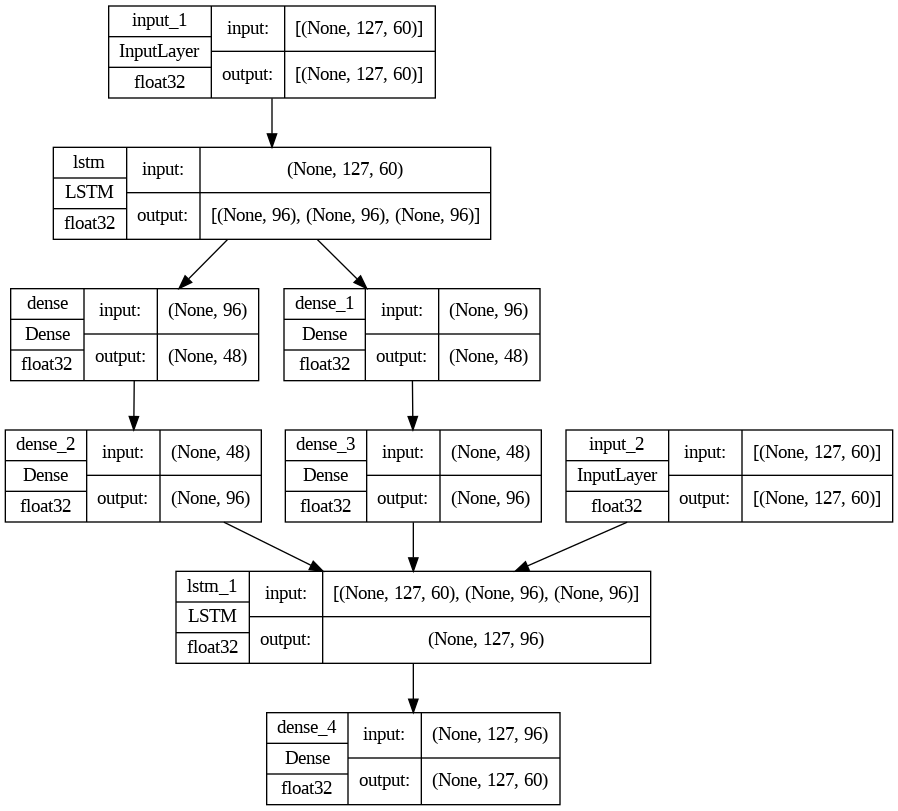

In [ ]:
keras.utils.plot_model(
    model,
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',     # Takip edilen metrik
    patience=10,            # 10 epoch boyunca iyileşme olmazsa durur
    restore_best_weights=True
)
# fit the model
#nb_epochs = 250
##validation_steps = len(X_val) // batch_size
#history = model.fit(training_generator, steps_per_epoch=steps_per_epoch, epochs=nb_epochs, verbose=1,
                              #validation_data=validation_generator, validation_steps=validation_steps,
                             #use_multiprocessing=False, shuffle=True, callbacks=[])
history = model.fit(
    training_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=250,
    verbose=1,
    validation_data=validation_generator,
    callbacks=[early_stop]  # EarlyStopping burada aktif edildi
)



Epoch 1/250
61/61 [==============================] - 14s 148ms/step - loss: 0.2335 - acc: 0.5668 - f1: 0.0530 - recall: 0.0524 - precision: 0.5441 - npv: 0.0535 - val_loss: 0.0475 - val_acc: 0.5907 - val_f1: 0.5953 - val_recall: 0.5906 - val_precision: 0.6001 - val_npv: 0.6001
Epoch 2/250
61/61 [==============================] - 8s 134ms/step - loss: 0.0457 - acc: 0.5684 - f1: 0.5708 - recall: 0.5684 - precision: 0.5732 - npv: 0.5732 - val_loss: 0.0426 - val_acc: 0.5907 - val_f1: 0.5929 - val_recall: 0.5906 - val_precision: 0.5954 - val_npv: 0.5953
Epoch 3/250
61/61 [==============================] - 7s 118ms/step - loss: 0.0428 - acc: 0.5684 - f1: 0.5708 - recall: 0.5683 - precision: 0.5732 - npv: 0.5732 - val_loss: 0.0403 - val_acc: 0.5907 - val_f1: 0.5953 - val_recall: 0.5906 - val_precision: 0.6001 - val_npv: 0.6001
Epoch 4/250
61/61 [==============================] - 8s 134ms/step - loss: 0.0396 - acc: 0.5716 - f1: 0.6144 - recall: 0.5563 - precision: 0.6786 - npv: 0.6995 - val_lo

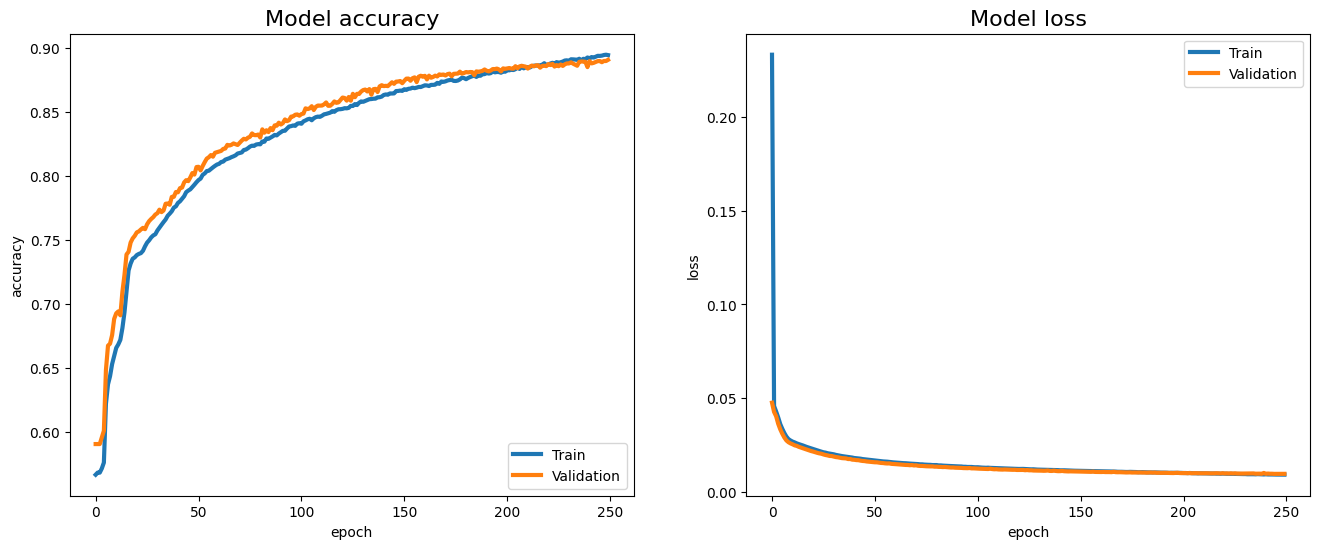

In [ ]:
# eğitilen lstm modelinin accuracy ve loss grafikleri
import matplotlib.pyplot as plt  # <-- Bu satırı mutlaka ekleyin

# eğitilen lstm modelinin accuracy ve loss grafikleri
fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

axis1.plot(history.history["acc"], label='Train', linewidth=3)
axis1.plot(history.history["val_acc"], label='Validation', linewidth=3)
axis1.set_title('Model accuracy', fontsize=16)
axis1.set_ylabel('accuracy')
axis1.set_xlabel('epoch')
axis1.legend(loc='lower right')

axis2.plot(history.history["loss"], label='Train', linewidth=3)
axis2.plot(history.history["val_loss"], label='Validation', linewidth=3)
axis2.set_title('Model loss', fontsize=16)
axis2.set_ylabel('loss')
axis2.set_xlabel('epoch')
axis2.legend(loc='upper right')

plt.show()

In [ ]:
encoder_model = Model(inputs=model.layers[0].input, outputs=model.layers[3].output)

In [ ]:
# encoder modelden gelen hidden state ve cell state değerlerini input olarak alıp sonraki decoder modele input olarak verecek olan model

latent_input = Input(shape=(48, ))
state_h = model.layers[5](latent_input)
state_c = model.layers[6](latent_input)
latent_to_states_model = Model(latent_input, [state_h, state_c])

In [ ]:
# ilaç üretecek olan kısım burası burada input katmanının 1,1,54 olması
# bu modelin çıktı olarak 54 feature'ı olan bir smiles vereceği anlamına gelir
decoder_inputs = Input(batch_shape=(1, 1, 60))
decoder_lstm = LSTM(96, return_sequences=True, stateful=True)(decoder_inputs)
decoder_outputs = Dense(60, activation='softmax')(decoder_lstm)
gen_model = Model(decoder_inputs, decoder_outputs)
for i in range(1,3):
    gen_model.layers[i].set_weights(model.layers[i+6].get_weights())

In [ ]:
# bu fonksiyonda kendi softmax fonskiyonumuzu yazıyoruz bu şekilde bir latent space oluşturabileceğiz
def sample_with_temp(preds, sampling_temp):
    streched = np.log(preds) / sampling_temp
    streched_probs = np.exp(streched) / np.sum(np.exp(streched))
    return np.random.choice(range(len(streched)), p=streched_probs)

In [ ]:
# Oluşan latent space'den sample smiles değerleri almak için fonksiyon
# oluşan latent space'i veriyoruz feature saıyısını veriyouz ve aktivasyon fonksiyonunun parametresini veriyoruz
def sample_smiles(latent, n_vocab, sampling_temp):
    states = latent_to_states_model.predict(latent)
    gen_model.layers[1].reset_states(states=[states[0], states[1]])

    startidx = char_to_int["$"]
    samplevec = np.zeros((1,1,n_vocab))
    samplevec[0,0,startidx] = 1
    sequence = ""

    for i in range(101):
        preds = gen_model.predict(samplevec)[0][-1]
        if sampling_temp == 1.0:
          sampleidx = np.argmax(preds)
        else:
          sampleidx = sample_with_temp(preds, sampling_temp)
        samplechar = int_to_char[str(sampleidx)]
        if samplechar != "X":
            sequence += samplechar
            samplevec = np.zeros((1,1,n_vocab))
            samplevec[0,0,sampleidx] = 1
        else:
            break
    return sequence

In [ ]:
# latent space etrafında smiles generationu yapıyoruz
def generate(latent_seed, sampling_temp, scale, quant):
  samples, mols = [], []
  i = 0
  while i < quant:
    latent_vec = latent_seed + scale*(np.random.randn(latent_seed.shape[1]))
    out = sample_smiles(latent_vec, n_vocab, sampling_temp)
    mol = Chem.MolFromSmiles(out)
    print(out, mol, i)
    if mol:

      try:
        RotBonds = Chem.Descriptors.NumRotatableBonds(mol)
        PSA = Chem.Descriptors.TPSA(mol)
        hDonorNum = Chem.Lipinski.NumHDonors(mol)
        hAcceptorNum = Chem.Lipinski.NumHAcceptors(mol)
        logp = Descriptors.MolLogP(mol)
        mol_weight = Descriptors.MolWt(mol)
        print(f'donor: {hDonorNum}, acceptor: {hAcceptorNum}, logp: {logp}, molweight: {mol_weight}')
        if hDonorNum <=5 and hAcceptorNum <= 10 and mol_weight <500 and logp <=5 and PSA <= 140 and RotBonds <= 10:
          i +=1
          mols.append(mol)
          samples.append(out)
      except:
        print('başaramadık')
  return mols, samples

In [ ]:
latent_space = encoder_model.predict(X_train)
latent_seed = latent_space[50:51]
sampling_temp = 0.75
scale = 0.5
quantity = 50
t_mols, t_smiles = generate(latent_seed, sampling_temp, scale, quantity)


1/1 [==============================] - 0s 16ms/step
Cl <rdkit.Chem.rdchem.Mol object at 0x7bc1b0d8b0d0> 0
donor: 0, acceptor: 0, logp: 0.4218, molweight: 36.461000000000006
1/1 [==============================] - 0s 17ms/step
Cl <rdkit.Chem.rdchem.Mol object at 0x7bc1b0d89f50> 1
donor: 0, acceptor: 0, logp: 0.4218, molweight: 36.461000000000006
1/1 [==============================] - 0s 17ms/step
N <rdkit.Chem.rdchem.Mol object at 0x7bc1c3927290> 2
donor: 1, acceptor: 1, logp: 0.16199999999999998, molweight: 17.031
1/1 [==============================] - 0s 17ms/step
CCCCCCCCCCCCCCCCCCCCCCCC(=O)Nc1cccccc1 None 3
1/1 [==============================] - 0s 16ms/step


[07:54:21] Can't kekulize mol.  Unkekulized atoms: 26 27 28 29 30 31 32


1/1 [==============================] - 0s 16ms/step
C=CCCCCCC(CCCC(c1ccccc2)cc(Cl)c(-c2ccc2 None 3
1/1 [==============================] - ETA: 0s

[07:54:23] SMILES Parse Error: extra open parentheses for input: 'C=CCCCCCC(CCCC(c1ccccc2)cc(Cl)c(-c2ccc2'


1/1 [==============================] - 0s 16ms/step
Cl)OC(=O)C2CCC(=O)C(CC(=O)c3ccccc3)O)O2 None 3
1/1 [==============================] - 0s 16ms/step


[07:54:25] SMILES Parse Error: extra close parentheses while parsing: Cl)OC(=O)C2CCC(=O)C(CC(=O)c3ccccc3)O)O2
[07:54:25] SMILES Parse Error: Failed parsing SMILES 'Cl)OC(=O)C2CCC(=O)C(CC(=O)c3ccccc3)O)O2' for input: 'Cl)OC(=O)C2CCC(=O)C(CC(=O)c3ccccc3)O)O2'


1/1 [==============================] - 0s 17ms/step
CO=C(C)(C)C(C)C(CSC(=O)N(C)C1CC(C)C(C)C None 3
1/1 [==============================] - 0s 17ms/step


[07:54:27] SMILES Parse Error: extra open parentheses for input: 'CO=C(C)(C)C(C)C(CSC(=O)N(C)C1CC(C)C(C)C'


1/1 [==============================] - 0s 17ms/step
CCCCCCCCCCCCCCCCCCCCP(=O)(O)OCC1(C)C(=O None 3
1/1 [==============================] - 0s 17ms/step


[07:54:29] SMILES Parse Error: extra open parentheses for input: 'CCCCCCCCCCCCCCCCCCCCP(=O)(O)OCC1(C)C(=O'


1/1 [==============================] - 0s 28ms/step
Cl)c1ccc(S(=O)(=O)Nc2nc3ccccc3N2(C)C)c1 None 3
1/1 [==============================] - 0s 26ms/step


[07:54:31] SMILES Parse Error: extra close parentheses while parsing: Cl)c1ccc(S(=O)(=O)Nc2nc3ccccc3N2(C)C)c1
[07:54:31] SMILES Parse Error: Failed parsing SMILES 'Cl)c1ccc(S(=O)(=O)Nc2nc3ccccc3N2(C)C)c1' for input: 'Cl)c1ccc(S(=O)(=O)Nc2nc3ccccc3N2(C)C)c1'


1/1 [==============================] - 0s 22ms/step
Cl <rdkit.Chem.rdchem.Mol object at 0x7bc1b0d8a180> 3
donor: 0, acceptor: 0, logp: 0.4218, molweight: 36.461000000000006
1/1 [==============================] - 0s 24ms/step
C=O <rdkit.Chem.rdchem.Mol object at 0x7bc1b0bd19a0> 4
donor: 0, acceptor: 1, logp: -0.1849, molweight: 30.026
1/1 [==============================] - 0s 26ms/step
Cl <rdkit.Chem.rdchem.Mol object at 0x7bc1b0d8aa40> 5
donor: 0, acceptor: 0, logp: 0.4218, molweight: 36.461000000000006
1/1 [==============================] - 0s 17ms/step
Cl)OC(CC(N=Nc1cc(O)c(OC)c1)C(=O)NC(C)C None 6
1/1 [==============================] - 0s 16ms/step


[07:54:34] SMILES Parse Error: extra close parentheses while parsing: Cl)OC(CC(N=Nc1cc(O)c(OC)c1)C(=O)NC(C)C
[07:54:34] SMILES Parse Error: Failed parsing SMILES 'Cl)OC(CC(N=Nc1cc(O)c(OC)c1)C(=O)NC(C)C' for input: 'Cl)OC(CC(N=Nc1cc(O)c(OC)c1)C(=O)NC(C)C'


1/1 [==============================] - 0s 20ms/step
Cl)OC(CS(=O)(O)C(OC(=O)NC(=O)CCCCCC1=C None 6
1/1 [==============================] - 0s 20ms/step


[07:54:37] SMILES Parse Error: extra close parentheses while parsing: Cl)OC(CS(=O)(O)C(OC(=O)NC(=O)CCCCCC1=C
[07:54:37] SMILES Parse Error: Failed parsing SMILES 'Cl)OC(CS(=O)(O)C(OC(=O)NC(=O)CCCCCC1=C' for input: 'Cl)OC(CS(=O)(O)C(OC(=O)NC(=O)CCCCCC1=C'


1/1 [==============================] - 0s 18ms/step
Cl)OC(C)CC(NS(=O)(=O)c1ccccc1)C(=O)Cc1cc None 6
1/1 [==============================] - 0s 17ms/step


[07:54:39] SMILES Parse Error: extra close parentheses while parsing: Cl)OC(C)CC(NS(=O)(=O)c1ccccc1)C(=O)Cc1cc
[07:54:39] SMILES Parse Error: Failed parsing SMILES 'Cl)OC(C)CC(NS(=O)(=O)c1ccccc1)C(=O)Cc1cc' for input: 'Cl)OC(C)CC(NS(=O)(=O)c1ccccc1)C(=O)Cc1cc'


1/1 [==============================] - 0s 17ms/step
CCCCCCCCCCCCCCCCCCCCCCC(=O)OCCC(OC(=O)O None 6
1/1 [==============================] - 0s 19ms/step
C <rdkit.Chem.rdchem.Mol object at 0x7bc1b0c3b8b0> 6
donor: 0, acceptor: 0, logp: 0.6361, molweight: 16.043


[07:54:41] SMILES Parse Error: extra open parentheses for input: 'CCCCCCCCCCCCCCCCCCCCCCC(=O)OCCC(OC(=O)O'


1/1 [==============================] - 0s 26ms/step
Cl)OC(=O)Nc2ccc(C=NNC(=O)c3ccccc3)c2)cc1 None 7
1/1 [==============================] - 0s 28ms/step


[07:54:44] SMILES Parse Error: extra close parentheses while parsing: Cl)OC(=O)Nc2ccc(C=NNC(=O)c3ccccc3)c2)cc1
[07:54:44] SMILES Parse Error: Failed parsing SMILES 'Cl)OC(=O)Nc2ccc(C=NNC(=O)c3ccccc3)c2)cc1' for input: 'Cl)OC(=O)Nc2ccc(C=NNC(=O)c3ccccc3)c2)cc1'


1/1 [==============================] - 0s 17ms/step
CBr)nocc1C2=C(OC(C)C(C)C3CC(C)c5cc(Cl)c1O None 7
1/1 [==============================] - 0s 18ms/step


[07:54:46] SMILES Parse Error: extra close parentheses while parsing: CBr)nocc1C2=C(OC(C)C(C)C3CC(C)c5cc(Cl)c1O
[07:54:46] SMILES Parse Error: Failed parsing SMILES 'CBr)nocc1C2=C(OC(C)C(C)C3CC(C)c5cc(Cl)c1O' for input: 'CBr)nocc1C2=C(OC(C)C(C)C3CC(C)c5cc(Cl)c1O'


1/1 [==============================] - 0s 17ms/step
Cl)OC(CC(NC(CC(N)C(NC(=O)C(C)C(N)C34ccccc3 None 7
1/1 [==============================] - ETA: 0s

[07:54:49] SMILES Parse Error: extra close parentheses while parsing: Cl)OC(CC(NC(CC(N)C(NC(=O)C(C)C(N)C34ccccc3
[07:54:49] SMILES Parse Error: Failed parsing SMILES 'Cl)OC(CC(NC(CC(N)C(NC(=O)C(C)C(N)C34ccccc3' for input: 'Cl)OC(CC(NC(CC(N)C(NC(=O)C(C)C(N)C34ccccc3'


1/1 [==============================] - 0s 18ms/step
Cl)OC(CC(CSc1ccccc2)[nH]c2ccccc2[N+](=O)[O-] None 7
1/1 [==============================] - 0s 18ms/step


[07:54:51] SMILES Parse Error: extra close parentheses while parsing: Cl)OC(CC(CSc1ccccc2)[nH]c2ccccc2[N+](=O)[O-]
[07:54:51] SMILES Parse Error: Failed parsing SMILES 'Cl)OC(CC(CSc1ccccc2)[nH]c2ccccc2[N+](=O)[O-]' for input: 'Cl)OC(CC(CSc1ccccc2)[nH]c2ccccc2[N+](=O)[O-]'


1/1 [==============================] - 0s 17ms/step
C=O <rdkit.Chem.rdchem.Mol object at 0x7bc1b0b7aab0> 7
donor: 0, acceptor: 1, logp: -0.1849, molweight: 30.026
1/1 [==============================] - 0s 17ms/step
Cl)OC(=C(CCCN1C(=O)Nc1ccc(S(=O)(=O)Nc2n1 None 8
1/1 [==============================] - 0s 16ms/step
N <rdkit.Chem.rdchem.Mol object at 0x7bc1b0b79b60> 8
donor: 1, acceptor: 1, logp: 0.16199999999999998, molweight: 17.031


[07:54:53] SMILES Parse Error: extra close parentheses while parsing: Cl)OC(=C(CCCN1C(=O)Nc1ccc(S(=O)(=O)Nc2n1
[07:54:53] SMILES Parse Error: Failed parsing SMILES 'Cl)OC(=C(CCCN1C(=O)Nc1ccc(S(=O)(=O)Nc2n1' for input: 'Cl)OC(=C(CCCN1C(=O)Nc1ccc(S(=O)(=O)Nc2n1'


1/1 [==============================] - 0s 30ms/step
Cl)OP(=O)(=O)O)c2c(=O)c2nc2c(C#N)c(C)cc1 None 9
1/1 [==============================] - 0s 26ms/step


[07:54:56] SMILES Parse Error: extra close parentheses while parsing: Cl)OP(=O)(=O)O)c2c(=O)c2nc2c(C#N)c(C)cc1
[07:54:56] SMILES Parse Error: Failed parsing SMILES 'Cl)OP(=O)(=O)O)c2c(=O)c2nc2c(C#N)c(C)cc1' for input: 'Cl)OP(=O)(=O)O)c2c(=O)c2nc2c(C#N)c(C)cc1'


1/1 [==============================] - 0s 16ms/step
Cc2ccccc3c(=S)c2cc2ccccc2)n(C)c1)c1ccccc1 None 9
1/1 [==============================] - 0s 16ms/step
N <rdkit.Chem.rdchem.Mol object at 0x7bc1b0b7af80> 9
donor: 1, acceptor: 1, logp: 0.16199999999999998, molweight: 17.031
1/1 [==============================] - 0s 16ms/step


[07:54:59] SMILES Parse Error: extra close parentheses while parsing: Cc2ccccc3c(=S)c2cc2ccccc2)n(C)c1)c1ccccc1
[07:54:59] SMILES Parse Error: Failed parsing SMILES 'Cc2ccccc3c(=S)c2cc2ccccc2)n(C)c1)c1ccccc1' for input: 'Cc2ccccc3c(=S)c2cc2ccccc2)n(C)c1)c1ccccc1'


1/1 [==============================] - 0s 16ms/step
Cl)OC(C)c(NC(=O)Nc2ccccc2)c2ccccc2c1N=O None 10
1/1 [==============================] - 0s 16ms/step
Cl <rdkit.Chem.rdchem.Mol object at 0x7bc1b09a3f40> 10
donor: 0, acceptor: 0, logp: 0.4218, molweight: 36.461000000000006


[07:55:01] SMILES Parse Error: extra close parentheses while parsing: Cl)OC(C)c(NC(=O)Nc2ccccc2)c2ccccc2c1N=O
[07:55:01] SMILES Parse Error: Failed parsing SMILES 'Cl)OC(C)c(NC(=O)Nc2ccccc2)c2ccccc2c1N=O' for input: 'Cl)OC(C)c(NC(=O)Nc2ccccc2)c2ccccc2c1N=O'


1/1 [==============================] - 0s 18ms/step
Cn1CCC(=O)C2C(C#N)C4(C)C3CCNC4(C)N3cccc21 <rdkit.Chem.rdchem.Mol object at 0x7bc153f534c0> 11
donor: 1, acceptor: 5, logp: 1.4581799999999998, molweight: 312.417
1/1 [==============================] - 0s 16ms/step
Clc1cccccc1C(=O)CCNC(=S)Nc1cccccc2c1Cl None 12
1/1 [==============================] - 0s 16ms/step


[07:55:05] SMILES Parse Error: unclosed ring for input: 'Clc1cccccc1C(=O)CCNC(=S)Nc1cccccc2c1Cl'


1/1 [==============================] - 0s 28ms/step
Cl)OCC(SC(=C)CCCCN2C(=O)N(C)C(=O)NC(=O)C None 12
1/1 [==============================] - 0s 16ms/step
C <rdkit.Chem.rdchem.Mol object at 0x7bc1b0872420> 12
donor: 0, acceptor: 0, logp: 0.6361, molweight: 16.043


[07:55:09] SMILES Parse Error: extra close parentheses while parsing: Cl)OCC(SC(=C)CCCCN2C(=O)N(C)C(=O)NC(=O)C
[07:55:09] SMILES Parse Error: Failed parsing SMILES 'Cl)OCC(SC(=C)CCCCN2C(=O)N(C)C(=O)NC(=O)C' for input: 'Cl)OCC(SC(=C)CCCCN2C(=O)N(C)C(=O)NC(=O)C'


1/1 [==============================] - 0s 16ms/step
Cl)OCC(CCCN(C(N)C(NC5CC(C)C)N(C)C6(C)C None 13
1/1 [==============================] - 0s 16ms/step


[07:55:11] SMILES Parse Error: extra close parentheses while parsing: Cl)OCC(CCCN(C(N)C(NC5CC(C)C)N(C)C6(C)C
[07:55:11] SMILES Parse Error: Failed parsing SMILES 'Cl)OCC(CCCN(C(N)C(NC5CC(C)C)N(C)C6(C)C' for input: 'Cl)OCC(CCCN(C(N)C(NC5CC(C)C)N(C)C6(C)C'


1/1 [==============================] - 0s 17ms/step
CCCCCCCCCCCCCCCCCCCCCCCCCc1cc(C(=O)OC)c1 <rdkit.Chem.rdchem.Mol object at 0x7bc1b08dece0> 13
donor: 0, acceptor: 2, logp: 10.408099999999994, molweight: 460.7870000000003
1/1 [==============================] - 0s 18ms/step
Cl)OC(=S)Nc2ccc(Cl)cc2)c(=O)[nH]c2ccccc12 None 13
1/1 [==============================] - 0s 16ms/step


[07:55:16] SMILES Parse Error: extra close parentheses while parsing: Cl)OC(=S)Nc2ccc(Cl)cc2)c(=O)[nH]c2ccccc12
[07:55:16] SMILES Parse Error: Failed parsing SMILES 'Cl)OC(=S)Nc2ccc(Cl)cc2)c(=O)[nH]c2ccccc12' for input: 'Cl)OC(=S)Nc2ccc(Cl)cc2)c(=O)[nH]c2ccccc12'


1/1 [==============================] - 0s 17ms/step
Cl)c1cccccc1S(=O)(=O)c1ccc(Cl)cc1)c1ccc None 13
1/1 [==============================] - 0s 18ms/step


[07:55:18] SMILES Parse Error: extra close parentheses while parsing: Cl)c1cccccc1S(=O)(=O)c1ccc(Cl)cc1)c1ccc
[07:55:18] SMILES Parse Error: Failed parsing SMILES 'Cl)c1cccccc1S(=O)(=O)c1ccc(Cl)cc1)c1ccc' for input: 'Cl)c1cccccc1S(=O)(=O)c1ccc(Cl)cc1)c1ccc'


1/1 [==============================] - 0s 17ms/step
CO=C(NC(=O)Cc2ccccc2)c(n2C1OC(C)C)C(C)C None 13
1/1 [==============================] - 0s 16ms/step


[07:55:22] SMILES Parse Error: unclosed ring for input: 'CO=C(NC(=O)Cc2ccccc2)c(n2C1OC(C)C)C(C)C'


1/1 [==============================] - 0s 25ms/step
Cl)OC(CC(=O)C(C(=O)CCCNC(=S)Nc1ccccc2ccc1 None 13
1/1 [==============================] - 0s 49ms/step


[07:55:24] SMILES Parse Error: extra close parentheses while parsing: Cl)OC(CC(=O)C(C(=O)CCCNC(=S)Nc1ccccc2ccc1
[07:55:24] SMILES Parse Error: Failed parsing SMILES 'Cl)OC(CC(=O)C(C(=O)CCCNC(=S)Nc1ccccc2ccc1' for input: 'Cl)OC(CC(=O)C(C(=O)CCCNC(=S)Nc1ccccc2ccc1'


1/1 [==============================] - 0s 15ms/step
Cl)OC(C)C(Cc1ccccc2c(-c2ccc(C=NNC(=O)Nc2 None 13
1/1 [==============================] - 0s 29ms/step


[07:55:27] SMILES Parse Error: extra close parentheses while parsing: Cl)OC(C)C(Cc1ccccc2c(-c2ccc(C=NNC(=O)Nc2
[07:55:27] SMILES Parse Error: Failed parsing SMILES 'Cl)OC(C)C(Cc1ccccc2c(-c2ccc(C=NNC(=O)Nc2' for input: 'Cl)OC(C)C(Cc1ccccc2c(-c2ccc(C=NNC(=O)Nc2'


1/1 [==============================] - 0s 16ms/step
Cl)OC(CC(NC(=O)CCC(C)C(C)C(C)C(C)C(C)C None 13
1/1 [==============================] - 0s 18ms/step


[07:55:30] SMILES Parse Error: extra close parentheses while parsing: Cl)OC(CC(NC(=O)CCC(C)C(C)C(C)C(C)C(C)C
[07:55:30] SMILES Parse Error: Failed parsing SMILES 'Cl)OC(CC(NC(=O)CCC(C)C(C)C(C)C(C)C(C)C' for input: 'Cl)OC(CC(NC(=O)CCC(C)C(C)C(C)C(C)C(C)C'


1/1 [==============================] - 0s 25ms/step
CO=O)Occccc2c1N=Nc1ccc1-c1ccc(Cl)cc2c1C None 13
1/1 [==============================] - 0s 24ms/step


[07:55:32] SMILES Parse Error: extra close parentheses while parsing: CO=O)Occccc2c1N=Nc1ccc1-c1ccc(Cl)cc2c1C
[07:55:32] SMILES Parse Error: Failed parsing SMILES 'CO=O)Occccc2c1N=Nc1ccc1-c1ccc(Cl)cc2c1C' for input: 'CO=O)Occccc2c1N=Nc1ccc1-c1ccc(Cl)cc2c1C'


1/1 [==============================] - 0s 17ms/step
Cl)OC(CC(NC(N(C)C(SS(=O)(=O)O)C(=O)NCCC None 13
1/1 [==============================] - 0s 16ms/step


[07:55:34] SMILES Parse Error: extra close parentheses while parsing: Cl)OC(CC(NC(N(C)C(SS(=O)(=O)O)C(=O)NCCC
[07:55:34] SMILES Parse Error: Failed parsing SMILES 'Cl)OC(CC(NC(N(C)C(SS(=O)(=O)O)C(=O)NCCC' for input: 'Cl)OC(CC(NC(N(C)C(SS(=O)(=O)O)C(=O)NCCC'


1/1 [==============================] - 0s 17ms/step
COc2ccccc(C(=O)O)cc2)cn2ccccc2[nH]c(=O)[n+] None 13
1/1 [==============================] - 0s 17ms/step


[07:55:37] SMILES Parse Error: extra close parentheses while parsing: COc2ccccc(C(=O)O)cc2)cn2ccccc2[nH]c(=O)[n+]
[07:55:37] SMILES Parse Error: Failed parsing SMILES 'COc2ccccc(C(=O)O)cc2)cn2ccccc2[nH]c(=O)[n+]' for input: 'COc2ccccc(C(=O)O)cc2)cn2ccccc2[nH]c(=O)[n+]'


1/1 [==============================] - 0s 27ms/step
C=CCCC(=O)NC(CC(C)C(N=NN5C(N4)c4ccccc3o2 None 13
1/1 [==============================] - 0s 16ms/step


[07:55:40] SMILES Parse Error: extra open parentheses for input: 'C=CCCC(=O)NC(CC(C)C(N=NN5C(N4)c4ccccc3o2'


1/1 [==============================] - 0s 16ms/step
Cl <rdkit.Chem.rdchem.Mol object at 0x7bc153d78900> 13
donor: 0, acceptor: 0, logp: 0.4218, molweight: 36.461000000000006
1/1 [==============================] - 0s 15ms/step
C=O <rdkit.Chem.rdchem.Mol object at 0x7bc1b0abf5a0> 14
donor: 0, acceptor: 1, logp: -0.1849, molweight: 30.026
1/1 [==============================] - 0s 21ms/step
Cl)OC(NS(=O)(COc1ccccc2)OCCCC1OC(=O)NCC None 15
1/1 [==============================] - 0s 16ms/step


[07:55:42] SMILES Parse Error: extra close parentheses while parsing: Cl)OC(NS(=O)(COc1ccccc2)OCCCC1OC(=O)NCC
[07:55:42] SMILES Parse Error: Failed parsing SMILES 'Cl)OC(NS(=O)(COc1ccccc2)OCCCC1OC(=O)NCC' for input: 'Cl)OC(NS(=O)(COc1ccccc2)OCCCC1OC(=O)NCC'


1/1 [==============================] - 0s 16ms/step
Cc3 None 15
1/1 [==============================] - 0s 17ms/step


[07:55:42] SMILES Parse Error: unclosed ring for input: 'Cc3'


1/1 [==============================] - 0s 24ms/step
Cl)OC(=O)Nc2ccc(NC(=O)c3ccccc2)ccc1)c1cc None 15
1/1 [==============================] - 0s 24ms/step


[07:55:45] SMILES Parse Error: extra close parentheses while parsing: Cl)OC(=O)Nc2ccc(NC(=O)c3ccccc2)ccc1)c1cc
[07:55:45] SMILES Parse Error: Failed parsing SMILES 'Cl)OC(=O)Nc2ccc(NC(=O)c3ccccc2)ccc1)c1cc' for input: 'Cl)OC(=O)Nc2ccc(NC(=O)c3ccccc2)ccc1)c1cc'


1/1 [==============================] - 0s 15ms/step
Cl)OC(=O)C(CCC(=O)NC(CC(C)C(N)S(=O)CC2 None 15
1/1 [==============================] - 0s 16ms/step


[07:55:47] SMILES Parse Error: extra close parentheses while parsing: Cl)OC(=O)C(CCC(=O)NC(CC(C)C(N)S(=O)CC2
[07:55:47] SMILES Parse Error: Failed parsing SMILES 'Cl)OC(=O)C(CCC(=O)NC(CC(C)C(N)S(=O)CC2' for input: 'Cl)OC(=O)C(CCC(=O)NC(CC(C)C(N)S(=O)CC2'


1/1 [==============================] - 0s 16ms/step
CO=O)c1cc(S(=O)(=O)Nc2nc3ccccc2)cc2c1C None 15
1/1 [==============================] - 0s 18ms/step


[07:55:49] SMILES Parse Error: extra close parentheses while parsing: CO=O)c1cc(S(=O)(=O)Nc2nc3ccccc2)cc2c1C
[07:55:49] SMILES Parse Error: Failed parsing SMILES 'CO=O)c1cc(S(=O)(=O)Nc2nc3ccccc2)cc2c1C' for input: 'CO=O)c1cc(S(=O)(=O)Nc2nc3ccccc2)cc2c1C'


1/1 [==============================] - 0s 54ms/step
Cl)OC(CC(=O)Nc1cc(N=Nc2ccc(N=Nc3ccc(O)cc1 None 15
1/1 [==============================] - 0s 41ms/step


[07:55:52] SMILES Parse Error: extra close parentheses while parsing: Cl)OC(CC(=O)Nc1cc(N=Nc2ccc(N=Nc3ccc(O)cc1
[07:55:52] SMILES Parse Error: Failed parsing SMILES 'Cl)OC(CC(=O)Nc1cc(N=Nc2ccc(N=Nc3ccc(O)cc1' for input: 'Cl)OC(CC(=O)Nc1cc(N=Nc2ccc(N=Nc3ccc(O)cc1'


1/1 [==============================] - 0s 15ms/step
CCCCCCCCCCCCCCCCCCCCCCCCC(=O)OCCC(C)CC <rdkit.Chem.rdchem.Mol object at 0x7bc153938ba0> 15
donor: 0, acceptor: 2, logp: 10.95799999999999, molweight: 466.8350000000004
1/1 [==============================] - 0s 16ms/step
Cl <rdkit.Chem.rdchem.Mol object at 0x7bc153874580> 15
donor: 0, acceptor: 0, logp: 0.4218, molweight: 36.461000000000006
1/1 [==============================] - 0s 15ms/step
Cl)OC(C)(CC(Nc1ccccc2c1-c1ccc(C(=O)O)c1N None 16
1/1 [==============================] - 0s 16ms/step


[07:55:59] SMILES Parse Error: extra close parentheses while parsing: Cl)OC(C)(CC(Nc1ccccc2c1-c1ccc(C(=O)O)c1N
[07:55:59] SMILES Parse Error: Failed parsing SMILES 'Cl)OC(C)(CC(Nc1ccccc2c1-c1ccc(C(=O)O)c1N' for input: 'Cl)OC(C)(CC(Nc1ccccc2c1-c1ccc(C(=O)O)c1N'


1/1 [==============================] - 0s 17ms/step
Cl)OC(C=C(CCCC(C)N(C)C(C)C(C)CNN(C)CC4 None 16
1/1 [==============================] - 0s 15ms/step


[07:56:01] SMILES Parse Error: extra close parentheses while parsing: Cl)OC(C=C(CCCC(C)N(C)C(C)C(C)CNN(C)CC4
[07:56:01] SMILES Parse Error: Failed parsing SMILES 'Cl)OC(C=C(CCCC(C)N(C)C(C)C(C)CNN(C)CC4' for input: 'Cl)OC(C=C(CCCC(C)N(C)C(C)C(C)CNN(C)CC4'


1/1 [==============================] - 0s 16ms/step
C(=O)OC(C2(C)C2SCC(=O)CCCS(=O)(=O)OCC(=O None 16
1/1 [==============================] - 0s 15ms/step


[07:56:03] SMILES Parse Error: extra open parentheses for input: 'C(=O)OC(C2(C)C2SCC(=O)CCCS(=O)(=O)OCC(=O'


1/1 [==============================] - 0s 16ms/step
C#N <rdkit.Chem.rdchem.Mol object at 0x7bc1538765e0> 16
donor: 0, acceptor: 1, logp: 0.13978, molweight: 27.025999999999996
1/1 [==============================] - 0s 19ms/step
CCCCCCCCCCCCCCCCCCCC(=O)Nc1cccccc1-c1cc None 17
1/1 [==============================] - 0s 20ms/step


[07:56:05] SMILES Parse Error: unclosed ring for input: 'CCCCCCCCCCCCCCCCCCCC(=O)Nc1cccccc1-c1cc'


1/1 [==============================] - 0s 19ms/step
Cl)OC(C)c(S(=O)(=O)Nc2ccccc2c2nc3ccccc21 None 17
1/1 [==============================] - 0s 20ms/step


[07:56:07] SMILES Parse Error: extra close parentheses while parsing: Cl)OC(C)c(S(=O)(=O)Nc2ccccc2c2nc3ccccc21
[07:56:07] SMILES Parse Error: Failed parsing SMILES 'Cl)OC(C)c(S(=O)(=O)Nc2ccccc2c2nc3ccccc21' for input: 'Cl)OC(C)c(S(=O)(=O)Nc2ccccc2c2nc3ccccc21'


1/1 [==============================] - 0s 20ms/step
Cl)OC(C)CCC(O)C(Nc1ccccc21)CC(C)C(=O)O None 17
1/1 [==============================] - 0s 19ms/step


[07:56:10] SMILES Parse Error: extra close parentheses while parsing: Cl)OC(C)CCC(O)C(Nc1ccccc21)CC(C)C(=O)O
[07:56:10] SMILES Parse Error: Failed parsing SMILES 'Cl)OC(C)CCC(O)C(Nc1ccccc21)CC(C)C(=O)O' for input: 'Cl)OC(C)CCC(O)C(Nc1ccccc21)CC(C)C(=O)O'


1/1 [==============================] - 0s 16ms/step
C=CCCCC(CC(C)C(C)C(CS)NC(=O)NC(O)(C(C)C None 17
1/1 [==============================] - ETA: 0s

[07:56:12] SMILES Parse Error: extra open parentheses for input: 'C=CCCCC(CC(C)C(C)C(CS)NC(=O)NC(O)(C(C)C'


1/1 [==============================] - 0s 15ms/step
CCCCCCC(=O)Nc1ccc(O)c(S(=O)(=O)O)cc2c1C None 17
1/1 [==============================] - ETA: 0s

[07:56:14] SMILES Parse Error: unclosed ring for input: 'CCCCCCC(=O)Nc1ccc(O)c(S(=O)(=O)O)cc2c1C'


1/1 [==============================] - 0s 15ms/step
CCO=C(Nc1ccccc2-c(=O)c2cc(C)c(C(=O)O)cc1 None 17
1/1 [==============================] - 0s 15ms/step


[07:56:16] SMILES Parse Error: extra open parentheses for input: 'CCO=C(Nc1ccccc2-c(=O)c2cc(C)c(C(=O)O)cc1'


1/1 [==============================] - 0s 16ms/step
C[O-])c1-c2ccc(Br)cc2N=Nc1ccc(N=Nc2ccc2c1 None 17
1/1 [==============================] - 0s 16ms/step


[07:56:18] SMILES Parse Error: extra close parentheses while parsing: C[O-])c1-c2ccc(Br)cc2N=Nc1ccc(N=Nc2ccc2c1
[07:56:18] SMILES Parse Error: Failed parsing SMILES 'C[O-])c1-c2ccc(Br)cc2N=Nc1ccc(N=Nc2ccc2c1' for input: 'C[O-])c1-c2ccc(Br)cc2N=Nc1ccc(N=Nc2ccc2c1'


1/1 [==============================] - 0s 26ms/step
C(=O)OC(CSC(=O)NC(=O)C(=O)CN=S(=O)(Sc1ccc None 17
1/1 [==============================] - 0s 29ms/step


[07:56:20] SMILES Parse Error: extra open parentheses for input: 'C(=O)OC(CSC(=O)NC(=O)C(=O)CN=S(=O)(Sc1ccc'


N <rdkit.Chem.rdchem.Mol object at 0x7bc1b0871690> 17
donor: 1, acceptor: 1, logp: 0.16199999999999998, molweight: 17.031
1/1 [==============================] - 0s 22ms/step
Cl <rdkit.Chem.rdchem.Mol object at 0x7bc1b08712a0> 18
donor: 0, acceptor: 0, logp: 0.4218, molweight: 36.461000000000006
1/1 [==============================] - 0s 25ms/step
Cc1 None 19
1/1 [==============================] - 0s 25ms/step


[07:56:21] SMILES Parse Error: unclosed ring for input: 'Cc1'


1/1 [==============================] - 0s 25ms/step
Cl <rdkit.Chem.rdchem.Mol object at 0x7bc1b09a21f0> 19
donor: 0, acceptor: 0, logp: 0.4218, molweight: 36.461000000000006
1/1 [==============================] - 0s 30ms/step
N1 None 20
1/1 [==============================] - 0s 21ms/step


[07:56:21] SMILES Parse Error: unclosed ring for input: 'N1'


1/1 [==============================] - 0s 15ms/step
Cl)OC(CCCCN(C(C)C(C)C(=O)NC(C)C(C)C1CS None 20
1/1 [==============================] - 0s 15ms/step


[07:56:24] SMILES Parse Error: extra close parentheses while parsing: Cl)OC(CCCCN(C(C)C(C)C(=O)NC(C)C(C)C1CS
[07:56:24] SMILES Parse Error: Failed parsing SMILES 'Cl)OC(CCCCN(C(C)C(C)C(=O)NC(C)C(C)C1CS' for input: 'Cl)OC(CCCCN(C(C)C(C)C(=O)NC(C)C(C)C1CS'


1/1 [==============================] - 0s 16ms/step
CO=C(N)N(C(=O)NC(N=Nc2ccccc2C(=O)Nc2ccc None 20
1/1 [==============================] - 0s 16ms/step


[07:56:26] SMILES Parse Error: extra open parentheses for input: 'CO=C(N)N(C(=O)NC(N=Nc2ccccc2C(=O)Nc2ccc'


Cl <rdkit.Chem.rdchem.Mol object at 0x7bc153d7b920> 20
donor: 0, acceptor: 0, logp: 0.4218, molweight: 36.461000000000006
1/1 [==============================] - 0s 25ms/step
Cl)(C)(C)(C)C(CS(=O)COP(=O)OCCCCC(C)=O) None 21
1/1 [==============================] - 0s 15ms/step


[07:56:28] SMILES Parse Error: extra close parentheses while parsing: Cl)(C)(C)(C)C(CS(=O)COP(=O)OCCCCC(C)=O)
[07:56:28] SMILES Parse Error: Failed parsing SMILES 'Cl)(C)(C)(C)C(CS(=O)COP(=O)OCCCCC(C)=O)' for input: 'Cl)(C)(C)(C)C(CS(=O)COP(=O)OCCCCC(C)=O)'


1/1 [==============================] - 0s 15ms/step
Cl)c1cccc(NC(=O)Nc2ccc(C)cc(SSc2ccc2cc1 None 21
1/1 [==============================] - 0s 15ms/step


[07:56:30] SMILES Parse Error: extra close parentheses while parsing: Cl)c1cccc(NC(=O)Nc2ccc(C)cc(SSc2ccc2cc1
[07:56:30] SMILES Parse Error: Failed parsing SMILES 'Cl)c1cccc(NC(=O)Nc2ccc(C)cc(SSc2ccc2cc1' for input: 'Cl)c1cccc(NC(=O)Nc2ccc(C)cc(SSc2ccc2cc1'


1/1 [==============================] - 0s 15ms/step
Cl)OC(CS(=O)(O)C1CC(C2CCC(C)=O)C(C)C4C None 21
1/1 [==============================] - 0s 15ms/step


[07:56:32] SMILES Parse Error: extra close parentheses while parsing: Cl)OC(CS(=O)(O)C1CC(C2CCC(C)=O)C(C)C4C
[07:56:32] SMILES Parse Error: Failed parsing SMILES 'Cl)OC(CS(=O)(O)C1CC(C2CCC(C)=O)C(C)C4C' for input: 'Cl)OC(CS(=O)(O)C1CC(C2CCC(C)=O)C(C)C4C'


1/1 [==============================] - 0s 15ms/step
c2ncccn3c3nc3nc3ccccc3)c2)c(=O)[nH]c1=O)O None 21
1/1 [==============================] - 0s 15ms/step


[07:56:34] SMILES Parse Error: extra close parentheses while parsing: c2ncccn3c3nc3nc3ccccc3)c2)c(=O)[nH]c1=O)O
[07:56:34] SMILES Parse Error: Failed parsing SMILES 'c2ncccn3c3nc3nc3ccccc3)c2)c(=O)[nH]c1=O)O' for input: 'c2ncccn3c3nc3nc3ccccc3)c2)c(=O)[nH]c1=O)O'


1/1 [==============================] - 0s 15ms/step
Cl)OC(CC(CSC(=O)NNC(=S)Nc1ccccc2c(NC(=O)O None 21
1/1 [==============================] - 0s 15ms/step
N <rdkit.Chem.rdchem.Mol object at 0x7bc153f53ae0> 21
donor: 1, acceptor: 1, logp: 0.16199999999999998, molweight: 17.031
1/1 [==============================] - 0s 15ms/step


[07:56:36] SMILES Parse Error: extra close parentheses while parsing: Cl)OC(CC(CSC(=O)NNC(=S)Nc1ccccc2c(NC(=O)O
[07:56:36] SMILES Parse Error: Failed parsing SMILES 'Cl)OC(CC(CSC(=O)NNC(=S)Nc1ccccc2c(NC(=O)O' for input: 'Cl)OC(CC(CSC(=O)NNC(=S)Nc1ccccc2c(NC(=O)O'


1/1 [==============================] - 0s 15ms/step
CO=C(=O)c1ccc(N=Nc2ccc(S(=O)(=O)O)cc2)c1 None 22
1/1 [==============================] - 0s 15ms/step


[07:56:39] Explicit valence for atom # 1 O, 3, is greater than permitted


1/1 [==============================] - 0s 15ms/step
Cl)OC(NC(=Nc1ccc(NC(=O)C2=NCCC2CSc2ccccc1 None 22
1/1 [==============================] - 0s 15ms/step
Cl <rdkit.Chem.rdchem.Mol object at 0x7bc153d5e810> 22
donor: 0, acceptor: 0, logp: 0.4218, molweight: 36.461000000000006


[07:56:41] SMILES Parse Error: extra close parentheses while parsing: Cl)OC(NC(=Nc1ccc(NC(=O)C2=NCCC2CSc2ccccc1
[07:56:41] SMILES Parse Error: Failed parsing SMILES 'Cl)OC(NC(=Nc1ccc(NC(=O)C2=NCCC2CSc2ccccc1' for input: 'Cl)OC(NC(=Nc1ccc(NC(=O)C2=NCCC2CSc2ccccc1'


1/1 [==============================] - 0s 15ms/step
Cn1CC(C)(C)C(=O)C2(c3ccccc3)c(C)c(=O)[nH]1 None 23
1/1 [==============================] - 0s 15ms/step


[07:56:43] SMILES Parse Error: unclosed ring for input: 'Cn1CC(C)(C)C(=O)C2(c3ccccc3)c(C)c(=O)[nH]1'


1/1 [==============================] - 0s 27ms/step
N=O)ccn2n3C(=O)CCc2nc(O)ccc1)C(=O)NCCCOC None 23
1/1 [==============================] - 0s 22ms/step


[07:56:45] SMILES Parse Error: extra close parentheses while parsing: N=O)ccn2n3C(=O)CCc2nc(O)ccc1)C(=O)NCCCOC
[07:56:45] SMILES Parse Error: Failed parsing SMILES 'N=O)ccn2n3C(=O)CCc2nc(O)ccc1)C(=O)NCCCOC' for input: 'N=O)ccn2n3C(=O)CCc2nc(O)ccc1)C(=O)NCCCOC'


1/1 [==============================] - 0s 16ms/step
Cl)OC(=O)C(=O)Nc2ccc(C3=NNC(=O)C(O)CC3 None 23
1/1 [==============================] - 0s 15ms/step


[07:56:48] SMILES Parse Error: extra close parentheses while parsing: Cl)OC(=O)C(=O)Nc2ccc(C3=NNC(=O)C(O)CC3
[07:56:48] SMILES Parse Error: Failed parsing SMILES 'Cl)OC(=O)C(=O)Nc2ccc(C3=NNC(=O)C(O)CC3' for input: 'Cl)OC(=O)C(=O)Nc2ccc(C3=NNC(=O)C(O)CC3'


Cl <rdkit.Chem.rdchem.Mol object at 0x7bc153c85380> 23
donor: 0, acceptor: 0, logp: 0.4218, molweight: 36.461000000000006
1/1 [==============================] - 0s 16ms/step
C=CCCC <rdkit.Chem.rdchem.Mol object at 0x7bc153c57680> 24
donor: 0, acceptor: 0, logp: 1.9725, molweight: 70.13499999999999
1/1 [==============================] - 0s 15ms/step
N <rdkit.Chem.rdchem.Mol object at 0x7bc153877bc0> 25
donor: 1, acceptor: 1, logp: 0.16199999999999998, molweight: 17.031
1/1 [==============================] - 0s 16ms/step
Cl <rdkit.Chem.rdchem.Mol object at 0x7bc153e02ff0> 26
donor: 0, acceptor: 0, logp: 0.4218, molweight: 36.461000000000006
1/1 [==============================] - 0s 15ms/step
Cl <rdkit.Chem.rdchem.Mol object at 0x7bc1538e1af0> 27
donor: 0, acceptor: 0, logp: 0.4218, molweight: 36.461000000000006
1/1 [==============================] - 0s 15ms/step
C[OH2=O)(C(C)C2C(C)C3(C)C3O)O2)c(=O)[nH]c1 None 28
1/1 [==============================] - 0s 16ms/step


[07:56:51] SMILES Parse Error: syntax error while parsing: C[OH2=O)(C(C)C2C(C)C3(C)C3O)O2)c(=O)[nH]c1
[07:56:51] SMILES Parse Error: Failed parsing SMILES 'C[OH2=O)(C(C)C2C(C)C3(C)C3O)O2)c(=O)[nH]c1' for input: 'C[OH2=O)(C(C)C2C(C)C3(C)C3O)O2)c(=O)[nH]c1'


1/1 [==============================] - 0s 15ms/step
C(=O)OC(C)C(=O)NS(=O)C2(C)C(CS)CCC(F)(C) None 28
1/1 [==============================] - 0s 16ms/step


[07:56:53] SMILES Parse Error: unclosed ring for input: 'C(=O)OC(C)C(=O)NS(=O)C2(C)C(CS)CCC(F)(C)'


1/1 [==============================] - 0s 16ms/step
CCCCCCCCCCCCCCCCCCCCCCCC(F)(c1cccccc1OC None 28
1/1 [==============================] - 0s 15ms/step


[07:56:55] SMILES Parse Error: extra open parentheses for input: 'CCCCCCCCCCCCCCCCCCCCCCCC(F)(c1cccccc1OC'


1/1 [==============================] - 0s 22ms/step
CO=O)c1oc(=O)c2cc(-c3ccc(O)c(C(=O)O)c2)c1 None 28
1/1 [==============================] - 0s 21ms/step


[07:56:57] SMILES Parse Error: extra close parentheses while parsing: CO=O)c1oc(=O)c2cc(-c3ccc(O)c(C(=O)O)c2)c1
[07:56:57] SMILES Parse Error: Failed parsing SMILES 'CO=O)c1oc(=O)c2cc(-c3ccc(O)c(C(=O)O)c2)c1' for input: 'CO=O)c1oc(=O)c2cc(-c3ccc(O)c(C(=O)O)c2)c1'


1/1 [==============================] - 0s 15ms/step
Cl)c1cc(S(=O)(=O)Nc2ccccc2)sc2ccccc2c1=O None 28
1/1 [==============================] - 0s 16ms/step


[07:57:00] SMILES Parse Error: extra close parentheses while parsing: Cl)c1cc(S(=O)(=O)Nc2ccccc2)sc2ccccc2c1=O
[07:57:00] SMILES Parse Error: Failed parsing SMILES 'Cl)c1cc(S(=O)(=O)Nc2ccccc2)sc2ccccc2c1=O' for input: 'Cl)c1cc(S(=O)(=O)Nc2ccccc2)sc2ccccc2c1=O'


1/1 [==============================] - 0s 16ms/step
Cl)OC(=S(=O)(O)c1ccccc1)C(O)(CC(C)=O)C None 28
1/1 [==============================] - 0s 15ms/step


[07:57:01] SMILES Parse Error: extra close parentheses while parsing: Cl)OC(=S(=O)(O)c1ccccc1)C(O)(CC(C)=O)C
[07:57:01] SMILES Parse Error: Failed parsing SMILES 'Cl)OC(=S(=O)(O)c1ccccc1)C(O)(CC(C)=O)C' for input: 'Cl)OC(=S(=O)(O)c1ccccc1)C(O)(CC(C)=O)C'


1/1 [==============================] - 0s 15ms/step
Cl)(C)(C)C(N)c1ccc(NC(=S)c2ccc(C=Cc2ccc None 28
1/1 [==============================] - 0s 15ms/step


[07:57:03] SMILES Parse Error: extra close parentheses while parsing: Cl)(C)(C)C(N)c1ccc(NC(=S)c2ccc(C=Cc2ccc
[07:57:03] SMILES Parse Error: Failed parsing SMILES 'Cl)(C)(C)C(N)c1ccc(NC(=S)c2ccc(C=Cc2ccc' for input: 'Cl)(C)(C)C(N)c1ccc(NC(=S)c2ccc(C=Cc2ccc'


1/1 [==============================] - 0s 15ms/step
Cl)OC(CC(CCCNCN1CN(C)C(C)c2ccccccc1S(=O None 28
1/1 [==============================] - 0s 15ms/step


[07:57:05] SMILES Parse Error: extra close parentheses while parsing: Cl)OC(CC(CCCNCN1CN(C)C(C)c2ccccccc1S(=O
[07:57:05] SMILES Parse Error: Failed parsing SMILES 'Cl)OC(CC(CCCNCN1CN(C)C(C)c2ccccccc1S(=O' for input: 'Cl)OC(CC(CCCNCN1CN(C)C(C)c2ccccccc1S(=O'


1/1 [==============================] - 0s 17ms/step
Cc1 None 28
1/1 [==============================] - 0s 15ms/step
C <rdkit.Chem.rdchem.Mol object at 0x7bc1536a2e30> 28
donor: 0, acceptor: 0, logp: 0.6361, molweight: 16.043
1/1 [==============================] - 0s 15ms/step


[07:57:06] SMILES Parse Error: unclosed ring for input: 'Cc1'


1/1 [==============================] - 0s 15ms/step
Cl-cccccccc2c1NCC1(C)C(=O)NC(C)C(=O)NC(=O None 29
1/1 [==============================] - 0s 15ms/step


[07:57:08] SMILES Parse Error: extra open parentheses for input: 'Cl-cccccccc2c1NCC1(C)C(=O)NC(C)C(=O)NC(=O'


1/1 [==============================] - 0s 26ms/step
CCCCCCCCCCCCCCCCCCCCCCCCCCCCC(=O)OCCCC <rdkit.Chem.rdchem.Mol object at 0x7bc152cdadc0> 29
donor: 0, acceptor: 2, logp: 11.882299999999985, molweight: 494.8890000000005
1/1 [==============================] - 0s 15ms/step
CCCCCCCCCCCCCCCCCCCCCc1ccc(-c2ccc(C=Cc3c None 29
1/1 [==============================] - 0s 15ms/step


[07:57:12] SMILES Parse Error: extra open parentheses for input: 'CCCCCCCCCCCCCCCCCCCCCc1ccc(-c2ccc(C=Cc3c'


1/1 [==============================] - 0s 15ms/step
CCOCCC(O)N1c2ccccc2c(=O)[nH]c2ccccc2)cc1 None 29
1/1 [==============================] - 0s 16ms/step


[07:57:14] SMILES Parse Error: extra close parentheses while parsing: CCOCCC(O)N1c2ccccc2c(=O)[nH]c2ccccc2)cc1
[07:57:14] SMILES Parse Error: Failed parsing SMILES 'CCOCCC(O)N1c2ccccc2c(=O)[nH]c2ccccc2)cc1' for input: 'CCOCCC(O)N1c2ccccc2c(=O)[nH]c2ccccc2)cc1'


1/1 [==============================] - 0s 15ms/step
CCCCCC(=O)OCCC(CCNN(C(=O)OCC(=Nc3ccccc21 None 29
1/1 [==============================] - 0s 15ms/step


[07:57:17] SMILES Parse Error: extra open parentheses for input: 'CCCCCC(=O)OCCC(CCNN(C(=O)OCC(=Nc3ccccc21'


1/1 [==============================] - 0s 15ms/step
Clc1ccccccc1S(=O)(=O)c1ccccc2c1N=Nc1ccc1 None 29
1/1 [==============================] - 0s 15ms/step


[07:57:19] SMILES Parse Error: unclosed ring for input: 'Clc1ccccccc1S(=O)(=O)c1ccccc2c1N=Nc1ccc1'


Cl <rdkit.Chem.rdchem.Mol object at 0x7bc1534d1d20> 29
donor: 0, acceptor: 0, logp: 0.4218, molweight: 36.461000000000006
1/1 [==============================] - 0s 22ms/step
Cl)OC(=C(CCCCCCCNC(=S(=O)O)OC(CSCSCC(=O)O None 30
1/1 [==============================] - 0s 21ms/step


[07:57:21] SMILES Parse Error: extra close parentheses while parsing: Cl)OC(=C(CCCCCCCNC(=S(=O)O)OC(CSCSCC(=O)O
[07:57:21] SMILES Parse Error: Failed parsing SMILES 'Cl)OC(=C(CCCCCCCNC(=S(=O)O)OC(CSCSCC(=O)O' for input: 'Cl)OC(=C(CCCCCCCNC(=S(=O)O)OC(CSCSCC(=O)O'


1/1 [==============================] - 0s 15ms/step
Cl-]P(=O)(C)CCC2CCCN3CCC(C)C)C(C)C(C)C None 30
1/1 [==============================] - 0s 16ms/step


[07:57:23] SMILES Parse Error: syntax error while parsing: Cl-]P(=O)(C)CCC2CCCN3CCC(C)C)C(C)C(C)C
[07:57:23] SMILES Parse Error: Failed parsing SMILES 'Cl-]P(=O)(C)CCC2CCCN3CCC(C)C)C(C)C(C)C' for input: 'Cl-]P(=O)(C)CCC2CCCN3CCC(C)C)C(C)C(C)C'


1/1 [==============================] - 0s 20ms/step
Cl)OC(C)C(CC(Nc1ccccc2)c(NC(=O)OCC2)cc1 None 30
1/1 [==============================] - 0s 20ms/step
N <rdkit.Chem.rdchem.Mol object at 0x7bc1536a2490> 30
donor: 1, acceptor: 1, logp: 0.16199999999999998, molweight: 17.031


[07:57:26] SMILES Parse Error: extra close parentheses while parsing: Cl)OC(C)C(CC(Nc1ccccc2)c(NC(=O)OCC2)cc1
[07:57:26] SMILES Parse Error: Failed parsing SMILES 'Cl)OC(C)C(CC(Nc1ccccc2)c(NC(=O)OCC2)cc1' for input: 'Cl)OC(C)C(CC(Nc1ccccc2)c(NC(=O)OCC2)cc1'


1/1 [==============================] - 0s 21ms/step
Cl <rdkit.Chem.rdchem.Mol object at 0x7bc153e030d0> 31
donor: 0, acceptor: 0, logp: 0.4218, molweight: 36.461000000000006
1/1 [==============================] - 0s 19ms/step
CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCc1c(Br)cccc None 32
1/1 [==============================] - 0s 21ms/step


[07:57:29] SMILES Parse Error: unclosed ring for input: 'CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCc1c(Br)cccc'


1/1 [==============================] - 0s 17ms/step
CO=O)c2cc(O)cc(Cc3ccc(-c4ccc4c3c3c(O)ccc12 None 32
1/1 [==============================] - 0s 18ms/step


[07:57:31] SMILES Parse Error: extra close parentheses while parsing: CO=O)c2cc(O)cc(Cc3ccc(-c4ccc4c3c3c(O)ccc12
[07:57:31] SMILES Parse Error: Failed parsing SMILES 'CO=O)c2cc(O)cc(Cc3ccc(-c4ccc4c3c3c(O)ccc12' for input: 'CO=O)c2cc(O)cc(Cc3ccc(-c4ccc4c3c3c(O)ccc12'


Cl <rdkit.Chem.rdchem.Mol object at 0x7bc1538767a0> 32
donor: 0, acceptor: 0, logp: 0.4218, molweight: 36.461000000000006
1/1 [==============================] - 0s 27ms/step
Cl)c1cn(C2CC(CO)C(CO)O2)c(=O)[nH]c2ccccc12 None 33
1/1 [==============================] - 0s 25ms/step


[07:57:34] SMILES Parse Error: extra close parentheses while parsing: Cl)c1cn(C2CC(CO)C(CO)O2)c(=O)[nH]c2ccccc12
[07:57:34] SMILES Parse Error: Failed parsing SMILES 'Cl)c1cn(C2CC(CO)C(CO)O2)c(=O)[nH]c2ccccc12' for input: 'Cl)c1cn(C2CC(CO)C(CO)O2)c(=O)[nH]c2ccccc12'


1/1 [==============================] - 0s 15ms/step
Cl)OC(CC(=O)Cc2ccccc2)nc(NC(=O)c2ccccc21 None 33
1/1 [==============================] - 0s 15ms/step
Cl <rdkit.Chem.rdchem.Mol object at 0x7bc153d5e3b0> 33
donor: 0, acceptor: 0, logp: 0.4218, molweight: 36.461000000000006


[07:57:37] SMILES Parse Error: extra close parentheses while parsing: Cl)OC(CC(=O)Cc2ccccc2)nc(NC(=O)c2ccccc21
[07:57:37] SMILES Parse Error: Failed parsing SMILES 'Cl)OC(CC(=O)Cc2ccccc2)nc(NC(=O)c2ccccc21' for input: 'Cl)OC(CC(=O)Cc2ccccc2)nc(NC(=O)c2ccccc21'


1/1 [==============================] - 0s 15ms/step
Cl)c1ccc(NN=Cc2ccc(N=Nc3ccc(N=Nc4ccc(S(=O)O None 34
1/1 [==============================] - 0s 19ms/step


[07:57:39] SMILES Parse Error: extra close parentheses while parsing: Cl)c1ccc(NN=Cc2ccc(N=Nc3ccc(N=Nc4ccc(S(=O)O
[07:57:39] SMILES Parse Error: Failed parsing SMILES 'Cl)c1ccc(NN=Cc2ccc(N=Nc3ccc(N=Nc4ccc(S(=O)O' for input: 'Cl)c1ccc(NN=Cc2ccc(N=Nc3ccc(N=Nc4ccc(S(=O)O'


1/1 [==============================] - 0s 15ms/step
Cl)O[nH]c2ccc(C(=O)Nc2ccccc2)n2cc(C)cc1O None 34
1/1 [==============================] - 0s 15ms/step


[07:57:41] SMILES Parse Error: extra close parentheses while parsing: Cl)O[nH]c2ccc(C(=O)Nc2ccccc2)n2cc(C)cc1O
[07:57:41] SMILES Parse Error: Failed parsing SMILES 'Cl)O[nH]c2ccc(C(=O)Nc2ccccc2)n2cc(C)cc1O' for input: 'Cl)O[nH]c2ccc(C(=O)Nc2ccccc2)n2cc(C)cc1O'


1/1 [==============================] - 0s 23ms/step
Cl)(C)C(C)C(NC(Nc1ccccccc1N=Nc1ccc(Nc2c1 None 34
1/1 [==============================] - 0s 25ms/step


[07:57:44] SMILES Parse Error: extra close parentheses while parsing: Cl)(C)C(C)C(NC(Nc1ccccccc1N=Nc1ccc(Nc2c1
[07:57:44] SMILES Parse Error: Failed parsing SMILES 'Cl)(C)C(C)C(NC(Nc1ccccccc1N=Nc1ccc(Nc2c1' for input: 'Cl)(C)C(C)C(NC(Nc1ccccccc1N=Nc1ccc(Nc2c1'


1/1 [==============================] - 0s 23ms/step
CO=Br)cn(C2CCC(N=[N+]=[N-])C(CO)O2)C(=O)O2 None 34
1/1 [==============================] - 0s 22ms/step


[07:57:46] SMILES Parse Error: extra close parentheses while parsing: CO=Br)cn(C2CCC(N=[N+]=[N-])C(CO)O2)C(=O)O2
[07:57:46] SMILES Parse Error: Failed parsing SMILES 'CO=Br)cn(C2CCC(N=[N+]=[N-])C(CO)O2)C(=O)O2' for input: 'CO=Br)cn(C2CCC(N=[N+]=[N-])C(CO)O2)C(=O)O2'


1/1 [==============================] - 0s 15ms/step
Cl)c1ccc(C(=O)Nc2ccc(C=Cc3ccc(N)c(C)cc32 None 34
1/1 [==============================] - 0s 15ms/step


[07:57:49] SMILES Parse Error: extra close parentheses while parsing: Cl)c1ccc(C(=O)Nc2ccc(C=Cc3ccc(N)c(C)cc32
[07:57:49] SMILES Parse Error: Failed parsing SMILES 'Cl)c1ccc(C(=O)Nc2ccc(C=Cc3ccc(N)c(C)cc32' for input: 'Cl)c1ccc(C(=O)Nc2ccc(C=Cc3ccc(N)c(C)cc32'


1/1 [==============================] - 0s 16ms/step
C[n+]1CCCCCCCCC(CO)O2)c(=O)[nH]c(=O)[nH]c1=O None 34
1/1 [==============================] - 0s 15ms/step


[07:57:51] SMILES Parse Error: extra close parentheses while parsing: C[n+]1CCCCCCCCC(CO)O2)c(=O)[nH]c(=O)[nH]c1=O
[07:57:51] SMILES Parse Error: Failed parsing SMILES 'C[n+]1CCCCCCCCC(CO)O2)c(=O)[nH]c(=O)[nH]c1=O' for input: 'C[n+]1CCCCCCCCC(CO)O2)c(=O)[nH]c(=O)[nH]c1=O'


1/1 [==============================] - 0s 15ms/step
Cc2 None 34
1/1 [==============================] - 0s 16ms/step


[07:57:51] SMILES Parse Error: unclosed ring for input: 'Cc2'


1/1 [==============================] - 0s 15ms/step
CCCCCCCCCCCCCCCCCCNC(=O)C(O)C(SC(=O)CCC None 34
1/1 [==============================] - 0s 15ms/step


[07:57:53] SMILES Parse Error: extra open parentheses for input: 'CCCCCCCCCCCCCCCCCCNC(=O)C(O)C(SC(=O)CCC'


1/1 [==============================] - 0s 15ms/step
Cl)OC(CC(CC(NP(=O)O)CCN(C(=O)OCC(=O)CCC None 34
1/1 [==============================] - 0s 15ms/step


[07:57:55] SMILES Parse Error: extra close parentheses while parsing: Cl)OC(CC(CC(NP(=O)O)CCN(C(=O)OCC(=O)CCC
[07:57:55] SMILES Parse Error: Failed parsing SMILES 'Cl)OC(CC(CC(NP(=O)O)CCN(C(=O)OCC(=O)CCC' for input: 'Cl)OC(CC(CC(NP(=O)O)CCN(C(=O)OCC(=O)CCC'


1/1 [==============================] - 0s 15ms/step
Cc2ccccc4c3n(C)=cc2c2)cccc1)c1ccc(S(=O)O None 34
1/1 [==============================] - 0s 15ms/step


[07:57:57] SMILES Parse Error: extra close parentheses while parsing: Cc2ccccc4c3n(C)=cc2c2)cccc1)c1ccc(S(=O)O
[07:57:57] SMILES Parse Error: Failed parsing SMILES 'Cc2ccccc4c3n(C)=cc2c2)cccc1)c1ccc(S(=O)O' for input: 'Cc2ccccc4c3n(C)=cc2c2)cccc1)c1ccc(S(=O)O'


1/1 [==============================] - 0s 15ms/step
CCCCCCN(C)NN(C(N=NC(Nc2cccccc2c2c(N)cc1 None 34
1/1 [==============================] - ETA: 0s

[07:58:00] SMILES Parse Error: extra open parentheses for input: 'CCCCCCN(C)NN(C(N=NC(Nc2cccccc2c2c(N)cc1'


1/1 [==============================] - 0s 16ms/step
Cl <rdkit.Chem.rdchem.Mol object at 0x7bc1b0872260> 34
donor: 0, acceptor: 0, logp: 0.4218, molweight: 36.461000000000006
1/1 [==============================] - 0s 25ms/step
Cl)OP(=O)(O)O)cc(C(=O)Nc2ccc(C=NNC(=O)C2 None 35
1/1 [==============================] - 0s 16ms/step


[07:58:02] SMILES Parse Error: extra close parentheses while parsing: Cl)OP(=O)(O)O)cc(C(=O)Nc2ccc(C=NNC(=O)C2
[07:58:02] SMILES Parse Error: Failed parsing SMILES 'Cl)OP(=O)(O)O)cc(C(=O)Nc2ccc(C=NNC(=O)C2' for input: 'Cl)OP(=O)(O)O)cc(C(=O)Nc2ccc(C=NNC(=O)C2'


1/1 [==============================] - 0s 15ms/step
Cl)OC(CC(NN(C(=O)c2ccccc2)n2C(=O)OCC(C)C None 35
1/1 [==============================] - 0s 15ms/step


[07:58:04] SMILES Parse Error: extra close parentheses while parsing: Cl)OC(CC(NN(C(=O)c2ccccc2)n2C(=O)OCC(C)C
[07:58:04] SMILES Parse Error: Failed parsing SMILES 'Cl)OC(CC(NN(C(=O)c2ccccc2)n2C(=O)OCC(C)C' for input: 'Cl)OC(CC(NN(C(=O)c2ccccc2)n2C(=O)OCC(C)C'


1/1 [==============================] - 0s 18ms/step
Cl)OC(C)(CCCN(C(C)Nc1ccc(NC(=S)Nc2cccc2 None 35
1/1 [==============================] - 0s 16ms/step


[07:58:06] SMILES Parse Error: extra close parentheses while parsing: Cl)OC(C)(CCCN(C(C)Nc1ccc(NC(=S)Nc2cccc2
[07:58:06] SMILES Parse Error: Failed parsing SMILES 'Cl)OC(C)(CCCN(C(C)Nc1ccc(NC(=S)Nc2cccc2' for input: 'Cl)OC(C)(CCCN(C(C)Nc1ccc(NC(=S)Nc2cccc2'


1/1 [==============================] - 0s 17ms/step
Cl)OC(CC(N=NN(C(C)(C)C(N=N4CC(C)CC(C)C)c2 None 35
1/1 [==============================] - 0s 15ms/step


[07:58:08] SMILES Parse Error: extra close parentheses while parsing: Cl)OC(CC(N=NN(C(C)(C)C(N=N4CC(C)CC(C)C)c2
[07:58:08] SMILES Parse Error: Failed parsing SMILES 'Cl)OC(CC(N=NN(C(C)(C)C(N=N4CC(C)CC(C)C)c2' for input: 'Cl)OC(CC(N=NN(C(C)(C)C(N=N4CC(C)CC(C)C)c2'


1/1 [==============================] - 0s 22ms/step
Cl)OC(CC(=O)C(CC(=O)NN(C(C)C)N(C2CCCC2) None 35
1/1 [==============================] - 0s 22ms/step


[07:58:11] SMILES Parse Error: extra close parentheses while parsing: Cl)OC(CC(=O)C(CC(=O)NN(C(C)C)N(C2CCCC2)
[07:58:11] SMILES Parse Error: Failed parsing SMILES 'Cl)OC(CC(=O)C(CC(=O)NN(C(C)C)N(C2CCCC2)' for input: 'Cl)OC(CC(=O)C(CC(=O)NN(C(C)C)N(C2CCCC2)'


1/1 [==============================] - 0s 21ms/step
Cl <rdkit.Chem.rdchem.Mol object at 0x7bc1b0861540> 35
donor: 0, acceptor: 0, logp: 0.4218, molweight: 36.461000000000006
1/1 [==============================] - 0s 15ms/step
CCCCCCCCCCCCCCCCCCCCCCCCC(=O)OP(=O)(O)O <rdkit.Chem.rdchem.Mol object at 0x7bc1b0abc4a0> 36
donor: 2, acceptor: 3, logp: 8.614500000000001, molweight: 462.6520000000002
1/1 [==============================] - 0s 15ms/step
C(=O)OC(C)C(=O)OCC(=O)C2CC(SSC(=O)(C)C)c None 36
1/1 [==============================] - 0s 15ms/step


[07:58:15] SMILES Parse Error: unclosed ring for input: 'C(=O)OC(C)C(=O)OCC(=O)C2CC(SSC(=O)(C)C)c'


1/1 [==============================] - 0s 16ms/step
Cl)OC(CC(N=[N+]2CCCNC(=O)N3CCC(C)C3=SCCN None 36
1/1 [==============================] - 0s 16ms/step


[07:58:17] SMILES Parse Error: extra close parentheses while parsing: Cl)OC(CC(N=[N+]2CCCNC(=O)N3CCC(C)C3=SCCN
[07:58:17] SMILES Parse Error: Failed parsing SMILES 'Cl)OC(CC(N=[N+]2CCCNC(=O)N3CCC(C)C3=SCCN' for input: 'Cl)OC(CC(N=[N+]2CCCNC(=O)N3CCC(C)C3=SCCN'


1/1 [==============================] - 0s 15ms/step
Cl)OP(=O)(=O)N2CCN3C(CO)CC4O)cc3)c(=O)[nH]1 None 36
1/1 [==============================] - 0s 15ms/step


[07:58:19] SMILES Parse Error: extra close parentheses while parsing: Cl)OP(=O)(=O)N2CCN3C(CO)CC4O)cc3)c(=O)[nH]1
[07:58:19] SMILES Parse Error: Failed parsing SMILES 'Cl)OP(=O)(=O)N2CCN3C(CO)CC4O)cc3)c(=O)[nH]1' for input: 'Cl)OP(=O)(=O)N2CCN3C(CO)CC4O)cc3)c(=O)[nH]1'


1/1 [==============================] - 0s 15ms/step
C(=O)OC(C=C2CC(C)N(C)C(C)CN4ccccc2S(=O) None 36
1/1 [==============================] - 0s 15ms/step


[07:58:21] SMILES Parse Error: extra open parentheses for input: 'C(=O)OC(C=C2CC(C)N(C)C(C)CN4ccccc2S(=O)'


1/1 [==============================] - 0s 15ms/step
Cl)OC(=S)Nc2ccc(Cl)cc2)c2c1C(=O)Nc1cccc1 None 36
1/1 [==============================] - 0s 15ms/step


[07:58:24] SMILES Parse Error: extra close parentheses while parsing: Cl)OC(=S)Nc2ccc(Cl)cc2)c2c1C(=O)Nc1cccc1
[07:58:24] SMILES Parse Error: Failed parsing SMILES 'Cl)OC(=S)Nc2ccc(Cl)cc2)c2c1C(=O)Nc1cccc1' for input: 'Cl)OC(=S)Nc2ccc(Cl)cc2)c2c1C(=O)Nc1cccc1'


1/1 [==============================] - 0s 16ms/step
Cc1 None 36
1/1 [==============================] - 0s 16ms/step


[07:58:24] SMILES Parse Error: unclosed ring for input: 'Cc1'


1/1 [==============================] - 0s 15ms/step
Cl)OC(C)c(NC(=O)Cc2ccccc2)c(S)cc1)c1ccc None 36
1/1 [==============================] - 0s 16ms/step
Cl <rdkit.Chem.rdchem.Mol object at 0x7bc1532f2110> 36
donor: 0, acceptor: 0, logp: 0.4218, molweight: 36.461000000000006


[07:58:26] SMILES Parse Error: extra close parentheses while parsing: Cl)OC(C)c(NC(=O)Cc2ccccc2)c(S)cc1)c1ccc
[07:58:26] SMILES Parse Error: Failed parsing SMILES 'Cl)OC(C)c(NC(=O)Cc2ccccc2)c(S)cc1)c1ccc' for input: 'Cl)OC(C)c(NC(=O)Cc2ccccc2)c(S)cc1)c1ccc'


1/1 [==============================] - 0s 15ms/step
Cl)(C)(C)(C)C(CC(N)(CC(Nc1ccccc2NC(=O)O None 37
1/1 [==============================] - 0s 16ms/step


[07:58:28] SMILES Parse Error: extra close parentheses while parsing: Cl)(C)(C)(C)C(CC(N)(CC(Nc1ccccc2NC(=O)O
[07:58:28] SMILES Parse Error: Failed parsing SMILES 'Cl)(C)(C)(C)C(CC(N)(CC(Nc1ccccc2NC(=O)O' for input: 'Cl)(C)(C)(C)C(CC(N)(CC(Nc1ccccc2NC(=O)O'


1/1 [==============================] - 0s 15ms/step
Cl)c1cc(S(=O)(=O)Nc2ccc(COCCCc3cccccc21.[NaH] None 37
1/1 [==============================] - 0s 15ms/step


[07:58:31] SMILES Parse Error: extra close parentheses while parsing: Cl)c1cc(S(=O)(=O)Nc2ccc(COCCCc3cccccc21.[NaH]
[07:58:31] SMILES Parse Error: Failed parsing SMILES 'Cl)c1cc(S(=O)(=O)Nc2ccc(COCCCc3cccccc21.[NaH]' for input: 'Cl)c1cc(S(=O)(=O)Nc2ccc(COCCCc3cccccc21.[NaH]'


1/1 [==============================] - 0s 15ms/step
Cl)c1cccccc1S(=O)(=O)c1ccc(Cl)cc1C(=O)OC None 37
1/1 [==============================] - 0s 15ms/step


[07:58:33] SMILES Parse Error: extra close parentheses while parsing: Cl)c1cccccc1S(=O)(=O)c1ccc(Cl)cc1C(=O)OC
[07:58:33] SMILES Parse Error: Failed parsing SMILES 'Cl)c1cccccc1S(=O)(=O)c1ccc(Cl)cc1C(=O)OC' for input: 'Cl)c1cccccc1S(=O)(=O)c1ccc(Cl)cc1C(=O)OC'


1/1 [==============================] - 0s 21ms/step
Cl)OC(CS(=O)(=O)c1ccccc1-c1ccccc1)c1ccc None 37
1/1 [==============================] - 0s 22ms/step


[07:58:35] SMILES Parse Error: extra close parentheses while parsing: Cl)OC(CS(=O)(=O)c1ccccc1-c1ccccc1)c1ccc
[07:58:35] SMILES Parse Error: Failed parsing SMILES 'Cl)OC(CS(=O)(=O)c1ccccc1-c1ccccc1)c1ccc' for input: 'Cl)OC(CS(=O)(=O)c1ccccc1-c1ccccc1)c1ccc'


1/1 [==============================] - 0s 15ms/step
Cl)OC(=N)Nc2cc(S(=O)(=O)O)c3S(=O)(=O)O)c1 None 37
1/1 [==============================] - 0s 15ms/step


[07:58:38] SMILES Parse Error: extra close parentheses while parsing: Cl)OC(=N)Nc2cc(S(=O)(=O)O)c3S(=O)(=O)O)c1
[07:58:38] SMILES Parse Error: Failed parsing SMILES 'Cl)OC(=N)Nc2cc(S(=O)(=O)O)c3S(=O)(=O)O)c1' for input: 'Cl)OC(=N)Nc2cc(S(=O)(=O)O)c3S(=O)(=O)O)c1'


1/1 [==============================] - 0s 15ms/step
C[O-]2cccc3)c2c1S(=O)(=O)c1ccccc1)SCC(=O)O None 37
1/1 [==============================] - 0s 15ms/step


[07:58:40] SMILES Parse Error: extra close parentheses while parsing: C[O-]2cccc3)c2c1S(=O)(=O)c1ccccc1)SCC(=O)O
[07:58:40] SMILES Parse Error: Failed parsing SMILES 'C[O-]2cccc3)c2c1S(=O)(=O)c1ccccc1)SCC(=O)O' for input: 'C[O-]2cccc3)c2c1S(=O)(=O)c1ccccc1)SCC(=O)O'


1/1 [==============================] - 0s 19ms/step
CCCCCCCCCCCCCCCCCCCCCCCc1ccc(-c2ccccc1 None 37
1/1 [==============================] - 0s 15ms/step


[07:58:42] SMILES Parse Error: extra open parentheses for input: 'CCCCCCCCCCCCCCCCCCCCCCCc1ccc(-c2ccccc1'


1/1 [==============================] - 0s 18ms/step
C[N=O)(=O)O)cc2c(NC(=O)c2ccccc2)cc1Cl)C1 None 37
1/1 [==============================] - 0s 16ms/step


[07:58:44] SMILES Parse Error: syntax error while parsing: C[N=O)(=O)O)cc2c(NC(=O)c2ccccc2)cc1Cl)C1
[07:58:44] SMILES Parse Error: Failed parsing SMILES 'C[N=O)(=O)O)cc2c(NC(=O)c2ccccc2)cc1Cl)C1' for input: 'C[N=O)(=O)O)cc2c(NC(=O)c2ccccc2)cc1Cl)C1'


1/1 [==============================] - 0s 16ms/step
C=O <rdkit.Chem.rdchem.Mol object at 0x7bc153499af0> 37
donor: 0, acceptor: 1, logp: -0.1849, molweight: 30.026
1/1 [==============================] - 0s 29ms/step
Cl)OC(=O)c2ccc(N=Nc3cc(O)cc(S(=O)(=O)O)c1 None 38
1/1 [==============================] - 0s 27ms/step


[07:58:47] SMILES Parse Error: extra close parentheses while parsing: Cl)OC(=O)c2ccc(N=Nc3cc(O)cc(S(=O)(=O)O)c1
[07:58:47] SMILES Parse Error: Failed parsing SMILES 'Cl)OC(=O)c2ccc(N=Nc3cc(O)cc(S(=O)(=O)O)c1' for input: 'Cl)OC(=O)c2ccc(N=Nc3cc(O)cc(S(=O)(=O)O)c1'


1/1 [==============================] - 0s 31ms/step
N <rdkit.Chem.rdchem.Mol object at 0x7bc1532f3a70> 38
donor: 1, acceptor: 1, logp: 0.16199999999999998, molweight: 17.031
1/1 [==============================] - 0s 20ms/step
CCCCCCCCCCCCCCCCCCCCCCCCCCCCC(=O)OCCCCC <rdkit.Chem.rdchem.Mol object at 0x7bc1b0863290> 39
donor: 0, acceptor: 2, logp: 12.272399999999982, molweight: 508.91600000000057
1/1 [==============================] - 0s 20ms/step
Cl <rdkit.Chem.rdchem.Mol object at 0x7bc1b08615b0> 39
donor: 0, acceptor: 0, logp: 0.4218, molweight: 36.461000000000006
1/1 [==============================] - 0s 18ms/step
Cl)OC(C)(CCCN(C(N)(C(C)C(N)N(C)C6CCCC None 40
1/1 [==============================] - 0s 18ms/step


[07:58:53] SMILES Parse Error: extra close parentheses while parsing: Cl)OC(C)(CCCN(C(N)(C(C)C(N)N(C)C6CCCC
[07:58:53] SMILES Parse Error: Failed parsing SMILES 'Cl)OC(C)(CCCN(C(N)(C(C)C(N)N(C)C6CCCC' for input: 'Cl)OC(C)(CCCN(C(N)(C(C)C(N)N(C)C6CCCC'


Cl <rdkit.Chem.rdchem.Mol object at 0x7bc1b0862810> 40
donor: 0, acceptor: 0, logp: 0.4218, molweight: 36.461000000000006
1/1 [==============================] - 0s 22ms/step
Cc2ccccc(C)cc3)OCC(=O)NC(=O)NC(=O)C1CCC None 41
1/1 [==============================] - 0s 16ms/step


[07:58:55] SMILES Parse Error: extra close parentheses while parsing: Cc2ccccc(C)cc3)OCC(=O)NC(=O)NC(=O)C1CCC
[07:58:55] SMILES Parse Error: Failed parsing SMILES 'Cc2ccccc(C)cc3)OCC(=O)NC(=O)NC(=O)C1CCC' for input: 'Cc2ccccc(C)cc3)OCC(=O)NC(=O)NC(=O)C1CCC'


1/1 [==============================] - 0s 20ms/step
CBr)nn(C(C)(C)C2(C(C)C)C(COC(=O)CCCCCCC None 41
1/1 [==============================] - 0s 15ms/step


[07:58:57] SMILES Parse Error: extra close parentheses while parsing: CBr)nn(C(C)(C)C2(C(C)C)C(COC(=O)CCCCCCC
[07:58:57] SMILES Parse Error: Failed parsing SMILES 'CBr)nn(C(C)(C)C2(C(C)C)C(COC(=O)CCCCCCC' for input: 'CBr)nn(C(C)(C)C2(C(C)C)C(COC(=O)CCCCCCC'


1/1 [==============================] - 0s 21ms/step
C=CCCCC(C)C(CCC(C)C(C)C(C)C43)c(C(=N)N2 None 41
1/1 [==============================] - 0s 21ms/step


[07:59:00] SMILES Parse Error: extra open parentheses for input: 'C=CCCCC(C)C(CCC(C)C(C)C(C)C43)c(C(=N)N2'


1/1 [==============================] - 0s 15ms/step
CCCCCCCCCCCCCCCC(O)CCC(O)CC(CCCC4(C)CC None 41
1/1 [==============================] - 0s 15ms/step


[07:59:02] SMILES Parse Error: extra open parentheses for input: 'CCCCCCCCCCCCCCCC(O)CCC(O)CC(CCCC4(C)CC'


1/1 [==============================] - 0s 15ms/step
C=CCCCCC(=O)OC(C(=O)OCCC(O)C(C)(C)C)CO2 None 41
1/1 [==============================] - 0s 15ms/step


[07:59:04] SMILES Parse Error: unclosed ring for input: 'C=CCCCCC(=O)OC(C(=O)OCCC(O)C(C)(C)C)CO2'


1/1 [==============================] - 0s 15ms/step
Cl)c1ccccc1S(=O)(O)C(OC(=O)CCCCCCC(CO)O2 None 41
1/1 [==============================] - 0s 16ms/step


[07:59:06] SMILES Parse Error: extra close parentheses while parsing: Cl)c1ccccc1S(=O)(O)C(OC(=O)CCCCCCC(CO)O2
[07:59:06] SMILES Parse Error: Failed parsing SMILES 'Cl)c1ccccc1S(=O)(O)C(OC(=O)CCCCCCC(CO)O2' for input: 'Cl)c1ccccc1S(=O)(O)C(OC(=O)CCCCCCC(CO)O2'


1/1 [==============================] - 0s 15ms/step
C#N <rdkit.Chem.rdchem.Mol object at 0x7bc1b0861930> 41
donor: 0, acceptor: 1, logp: 0.13978, molweight: 27.025999999999996
1/1 [==============================] - 0s 15ms/step
Cl <rdkit.Chem.rdchem.Mol object at 0x7bc1b0ec3ca0> 42
donor: 0, acceptor: 0, logp: 0.4218, molweight: 36.461000000000006
1/1 [==============================] - 0s 15ms/step
Cl)c1ccccc1S(=O)(=O)c1ccccc1C1N=NCNC(=O)N None 43
1/1 [==============================] - 0s 16ms/step


[07:59:09] SMILES Parse Error: extra close parentheses while parsing: Cl)c1ccccc1S(=O)(=O)c1ccccc1C1N=NCNC(=O)N
[07:59:09] SMILES Parse Error: Failed parsing SMILES 'Cl)c1ccccc1S(=O)(=O)c1ccccc1C1N=NCNC(=O)N' for input: 'Cl)c1ccccc1S(=O)(=O)c1ccccc1C1N=NCNC(=O)N'


1/1 [==============================] - 0s 15ms/step
Cl)OC(=O)C(=CC=CCCCCCCC(C)C(=O)CCC(C)C None 43
1/1 [==============================] - 0s 15ms/step
Cl <rdkit.Chem.rdchem.Mol object at 0x7bc1b0c38200> 43
donor: 0, acceptor: 0, logp: 0.4218, molweight: 36.461000000000006


[07:59:10] SMILES Parse Error: extra close parentheses while parsing: Cl)OC(=O)C(=CC=CCCCCCCC(C)C(=O)CCC(C)C
[07:59:10] SMILES Parse Error: Failed parsing SMILES 'Cl)OC(=O)C(=CC=CCCCCCCC(C)C(=O)CCC(C)C' for input: 'Cl)OC(=O)C(=CC=CCCCCCCC(C)C(=O)CCC(C)C'


1/1 [==============================] - 0s 15ms/step
Cl)OC(=O)C2C3C(COC(=O)N=CC(=O)CO2)c(=O)[nH] None 44
1/1 [==============================] - 0s 17ms/step


[07:59:14] SMILES Parse Error: extra close parentheses while parsing: Cl)OC(=O)C2C3C(COC(=O)N=CC(=O)CO2)c(=O)[nH]
[07:59:14] SMILES Parse Error: Failed parsing SMILES 'Cl)OC(=O)C2C3C(COC(=O)N=CC(=O)CO2)c(=O)[nH]' for input: 'Cl)OC(=O)C2C3C(COC(=O)N=CC(=O)CO2)c(=O)[nH]'


1/1 [==============================] - 0s 15ms/step
C=CCCC(CC(C)C(CC(N)C(C)C3CS(=O)CO)N2Br None 44
1/1 [==============================] - 0s 16ms/step


[07:59:16] SMILES Parse Error: extra open parentheses for input: 'C=CCCC(CC(C)C(CC(N)C(C)C3CS(=O)CO)N2Br'


1/1 [==============================] - 0s 15ms/step
C=CCCCCC(CCCC(C)NN(C(C)C(C)C(C)N3C(=O)C None 44
1/1 [==============================] - 0s 15ms/step


[07:59:18] SMILES Parse Error: extra open parentheses for input: 'C=CCCCCC(CCCC(C)NN(C(C)C(C)C(C)N3C(=O)C'


1/1 [==============================] - 0s 15ms/step
Cl)c1ccccc1S(=O)(=O)c1ccc(Cl)cc2c1)c1cc None 44
1/1 [==============================] - 0s 15ms/step


[07:59:20] SMILES Parse Error: extra close parentheses while parsing: Cl)c1ccccc1S(=O)(=O)c1ccc(Cl)cc2c1)c1cc
[07:59:20] SMILES Parse Error: Failed parsing SMILES 'Cl)c1ccccc1S(=O)(=O)c1ccc(Cl)cc2c1)c1cc' for input: 'Cl)c1ccccc1S(=O)(=O)c1ccc(Cl)cc2c1)c1cc'


1/1 [==============================] - 0s 16ms/step
Cl)OC(CC(C)C(NC(=S)Nc2cccccc2c(NC(=O)O)c1 None 44
1/1 [==============================] - 0s 15ms/step


[07:59:22] SMILES Parse Error: extra close parentheses while parsing: Cl)OC(CC(C)C(NC(=S)Nc2cccccc2c(NC(=O)O)c1
[07:59:22] SMILES Parse Error: Failed parsing SMILES 'Cl)OC(CC(C)C(NC(=S)Nc2cccccc2c(NC(=O)O)c1' for input: 'Cl)OC(CC(C)C(NC(=S)Nc2cccccc2c(NC(=O)O)c1'


1/1 [==============================] - 0s 34ms/step
Cl)OC(CC(Nc1ccccc1[N+](=O)[O-])c1ccccc1Cl None 44
1/1 [==============================] - 0s 23ms/step


[07:59:24] SMILES Parse Error: extra close parentheses while parsing: Cl)OC(CC(Nc1ccccc1[N+](=O)[O-])c1ccccc1Cl
[07:59:24] SMILES Parse Error: Failed parsing SMILES 'Cl)OC(CC(Nc1ccccc1[N+](=O)[O-])c1ccccc1Cl' for input: 'Cl)OC(CC(Nc1ccccc1[N+](=O)[O-])c1ccccc1Cl'


1/1 [==============================] - 0s 25ms/step
Cl <rdkit.Chem.rdchem.Mol object at 0x7bc153875380> 44
donor: 0, acceptor: 0, logp: 0.4218, molweight: 36.461000000000006
1/1 [==============================] - 0s 16ms/step
Cl)OC(CC(=Nc2cccc2)C(=O)NC(=O)N(C)C(=O)O None 45
1/1 [==============================] - 0s 15ms/step


[07:59:27] SMILES Parse Error: extra close parentheses while parsing: Cl)OC(CC(=Nc2cccc2)C(=O)NC(=O)N(C)C(=O)O
[07:59:27] SMILES Parse Error: Failed parsing SMILES 'Cl)OC(CC(=Nc2cccc2)C(=O)NC(=O)N(C)C(=O)O' for input: 'Cl)OC(CC(=Nc2cccc2)C(=O)NC(=O)N(C)C(=O)O'


1/1 [==============================] - 0s 16ms/step
CCCCCCCCCCCCCCCCCCCCCCCCCCCc1cc(F)(F)ccc None 45
1/1 [==============================] - 0s 15ms/step


[07:59:29] SMILES Parse Error: unclosed ring for input: 'CCCCCCCCCCCCCCCCCCCCCCCCCCCc1cc(F)(F)ccc'


1/1 [==============================] - 0s 15ms/step
CCCCCCCCC(=O)OC(CC(C)(C)C1CCC(C)C1=CCC None 45
1/1 [==============================] - ETA: 0s

[07:59:31] SMILES Parse Error: extra open parentheses for input: 'CCCCCCCCC(=O)OC(CC(C)(C)C1CCC(C)C1=CCC'


1/1 [==============================] - 0s 15ms/step
Cl-] None 45
1/1 [==============================] - 0s 15ms/step


[07:59:31] SMILES Parse Error: syntax error while parsing: Cl-]
[07:59:31] SMILES Parse Error: Failed parsing SMILES 'Cl-]' for input: 'Cl-]'


1/1 [==============================] - 0s 15ms/step
[NH]=CC(=O)OCC2CC3(CO)O2)c(=O)[nH]c2ccccc1 None 45
1/1 [==============================] - 0s 27ms/step


[07:59:34] SMILES Parse Error: extra close parentheses while parsing: [NH]=CC(=O)OCC2CC3(CO)O2)c(=O)[nH]c2ccccc1
[07:59:34] SMILES Parse Error: Failed parsing SMILES '[NH]=CC(=O)OCC2CC3(CO)O2)c(=O)[nH]c2ccccc1' for input: '[NH]=CC(=O)OCC2CC3(CO)O2)c(=O)[nH]c2ccccc1'


1/1 [==============================] - 0s 30ms/step
CCCCCCCCCCCCCCCCNC(=O)Nc1cccccc2c(S(=O)O None 45
1/1 [==============================] - 0s 25ms/step


[07:59:36] SMILES Parse Error: extra open parentheses for input: 'CCCCCCCCCCCCCCCCNC(=O)Nc1cccccc2c(S(=O)O'


1/1 [==============================] - 0s 16ms/step
Cl)c1ccccc2c(-c2ccc(Cl)c2)cc1Cl)c1ccccc1 None 45
1/1 [==============================] - 0s 17ms/step


[07:59:38] SMILES Parse Error: extra close parentheses while parsing: Cl)c1ccccc2c(-c2ccc(Cl)c2)cc1Cl)c1ccccc1
[07:59:38] SMILES Parse Error: Failed parsing SMILES 'Cl)c1ccccc2c(-c2ccc(Cl)c2)cc1Cl)c1ccccc1' for input: 'Cl)c1ccccc2c(-c2ccc(Cl)c2)cc1Cl)c1ccccc1'


1/1 [==============================] - 0s 16ms/step
Cl)OC(C)C(=S)c2ccccc2C(=O)c2ccccc2[nH]c1 None 45
1/1 [==============================] - 0s 16ms/step


[07:59:41] SMILES Parse Error: extra close parentheses while parsing: Cl)OC(C)C(=S)c2ccccc2C(=O)c2ccccc2[nH]c1
[07:59:41] SMILES Parse Error: Failed parsing SMILES 'Cl)OC(C)C(=S)c2ccccc2C(=O)c2ccccc2[nH]c1' for input: 'Cl)OC(C)C(=S)c2ccccc2C(=O)c2ccccc2[nH]c1'


1/1 [==============================] - 0s 16ms/step
C#N <rdkit.Chem.rdchem.Mol object at 0x7bc1532e8200> 45
donor: 0, acceptor: 1, logp: 0.13978, molweight: 27.025999999999996
1/1 [==============================] - 0s 16ms/step
C=CCCC(CC(C)C(NN(C(=O)NC(CC(N)N34)cccc21 None 46
1/1 [==============================] - 0s 16ms/step


[07:59:43] SMILES Parse Error: extra open parentheses for input: 'C=CCCC(CC(C)C(NN(C(=O)NC(CC(N)N34)cccc21'


1/1 [==============================] - 0s 17ms/step
Cl)OCC(CCCCC(O)C(OC(=O)C(CCC5CCC(C)C5C None 46
1/1 [==============================] - 0s 16ms/step
N <rdkit.Chem.rdchem.Mol object at 0x7bc1b09a19a0> 46
donor: 1, acceptor: 1, logp: 0.16199999999999998, molweight: 17.031


[07:59:45] SMILES Parse Error: extra close parentheses while parsing: Cl)OCC(CCCCC(O)C(OC(=O)C(CCC5CCC(C)C5C
[07:59:45] SMILES Parse Error: Failed parsing SMILES 'Cl)OCC(CCCCC(O)C(OC(=O)C(CCC5CCC(C)C5C' for input: 'Cl)OCC(CCCCC(O)C(OC(=O)C(CCC5CCC(C)C5C'


1/1 [==============================] - 0s 26ms/step
CCCCCCC(N)C(C)C(CC(NN(C(C)N3)c2ccccc-c1 None 47
1/1 [==============================] - 0s 23ms/step


[07:59:47] SMILES Parse Error: extra open parentheses for input: 'CCCCCCC(N)C(C)C(CC(NN(C(C)N3)c2ccccc-c1'


1/1 [==============================] - 0s 16ms/step
Cl)OC(CS(=O)(O)CCCN(C)C(CCC(=O)OCC(C)(C) None 47
1/1 [==============================] - 0s 16ms/step


[07:59:50] SMILES Parse Error: extra close parentheses while parsing: Cl)OC(CS(=O)(O)CCCN(C)C(CCC(=O)OCC(C)(C)
[07:59:50] SMILES Parse Error: Failed parsing SMILES 'Cl)OC(CS(=O)(O)CCCN(C)C(CCC(=O)OCC(C)(C)' for input: 'Cl)OC(CS(=O)(O)CCCN(C)C(CCC(=O)OCC(C)(C)'


1/1 [==============================] - 0s 16ms/step
CCO=C(NC(C(C)C(C)C(C)C(=O)NC4CCcc(S(=O)=O None 47
1/1 [==============================] - 0s 16ms/step


[07:59:53] SMILES Parse Error: extra open parentheses for input: 'CCO=C(NC(C(C)C(C)C(C)C(=O)NC4CCcc(S(=O)=O'


1/1 [==============================] - 0s 16ms/step
Cl)OC(CC(N=NC(=O)C(CCCN3CCCCCCCN4)ccc2c1 None 47
1/1 [==============================] - 0s 16ms/step


[07:59:55] SMILES Parse Error: extra close parentheses while parsing: Cl)OC(CC(N=NC(=O)C(CCCN3CCCCCCCN4)ccc2c1
[07:59:55] SMILES Parse Error: Failed parsing SMILES 'Cl)OC(CC(N=NC(=O)C(CCCN3CCCCCCCN4)ccc2c1' for input: 'Cl)OC(CC(N=NC(=O)C(CCCN3CCCCCCCN4)ccc2c1'


1/1 [==============================] - 0s 17ms/step
Cl)c1ccc(N=Nc2ccc(-c3ccc(N=O)cc3S(=O)(=O)O None 47
1/1 [==============================] - 0s 16ms/step


[07:59:57] SMILES Parse Error: extra close parentheses while parsing: Cl)c1ccc(N=Nc2ccc(-c3ccc(N=O)cc3S(=O)(=O)O
[07:59:57] SMILES Parse Error: Failed parsing SMILES 'Cl)c1ccc(N=Nc2ccc(-c3ccc(N=O)cc3S(=O)(=O)O' for input: 'Cl)c1ccc(N=Nc2ccc(-c3ccc(N=O)cc3S(=O)(=O)O'


1/1 [==============================] - 0s 15ms/step
Cl)On[nH]c(=O)[nH]c2c(Cl)cn2)cc1)c1ccc1C None 47
1/1 [==============================] - 0s 17ms/step


[07:59:59] SMILES Parse Error: extra close parentheses while parsing: Cl)On[nH]c(=O)[nH]c2c(Cl)cn2)cc1)c1ccc1C
[07:59:59] SMILES Parse Error: Failed parsing SMILES 'Cl)On[nH]c(=O)[nH]c2c(Cl)cn2)cc1)c1ccc1C' for input: 'Cl)On[nH]c(=O)[nH]c2c(Cl)cn2)cc1)c1ccc1C'


1/1 [==============================] - 0s 16ms/step
Cl <rdkit.Chem.rdchem.Mol object at 0x7bc152d1e8f0> 47
donor: 0, acceptor: 0, logp: 0.4218, molweight: 36.461000000000006
1/1 [==============================] - 0s 17ms/step
[N-]=O)[nH]c2ccccc2)nc(O)c2ccccc12)c1ccc None 48
1/1 [==============================] - 0s 16ms/step


[08:00:02] SMILES Parse Error: extra close parentheses while parsing: [N-]=O)[nH]c2ccccc2)nc(O)c2ccccc12)c1ccc
[08:00:02] SMILES Parse Error: Failed parsing SMILES '[N-]=O)[nH]c2ccccc2)nc(O)c2ccccc12)c1ccc' for input: '[N-]=O)[nH]c2ccccc2)nc(O)c2ccccc12)c1ccc'


1/1 [==============================] - 0s 15ms/step
CCCCCCCCCCCCCCCCCCCBrc1cc(Cl)c(O)c(OC)c1 None 48
1/1 [==============================] - 0s 16ms/step


[08:00:05] Explicit valence for atom # 19 Br, 2, is greater than permitted


1/1 [==============================] - 0s 15ms/step
CCCCCCCC#NC(CC(NC(N=NN=Cc2ccccc2c(N)cc1 None 48
1/1 [==============================] - 0s 16ms/step


[08:00:07] SMILES Parse Error: extra open parentheses for input: 'CCCCCCCC#NC(CC(NC(N=NN=Cc2ccccc2c(N)cc1'


1/1 [==============================] - 0s 16ms/step
Cl)CCCC(CC(NC(=S(N)C(C)=O)NC(C(=O)CN2 None 48
1/1 [==============================] - 0s 16ms/step


[08:00:09] SMILES Parse Error: extra close parentheses while parsing: Cl)CCCC(CC(NC(=S(N)C(C)=O)NC(C(=O)CN2
[08:00:09] SMILES Parse Error: Failed parsing SMILES 'Cl)CCCC(CC(NC(=S(N)C(C)=O)NC(C(=O)CN2' for input: 'Cl)CCCC(CC(NC(=S(N)C(C)=O)NC(C(=O)CN2'


1/1 [==============================] - 0s 19ms/step
Cl <rdkit.Chem.rdchem.Mol object at 0x7bc152b6b060> 48
donor: 0, acceptor: 0, logp: 0.4218, molweight: 36.461000000000006
1/1 [==============================] - 0s 20ms/step
Cl)OC(C)(CCCC(NNC(=O)NN(C(C)(C)C(N=N)N2 None 49
1/1 [==============================] - 0s 21ms/step


[08:00:12] SMILES Parse Error: extra close parentheses while parsing: Cl)OC(C)(CCCC(NNC(=O)NN(C(C)(C)C(N=N)N2
[08:00:12] SMILES Parse Error: Failed parsing SMILES 'Cl)OC(C)(CCCC(NNC(=O)NN(C(C)(C)C(N=N)N2' for input: 'Cl)OC(C)(CCCC(NNC(=O)NN(C(C)(C)C(N=N)N2'


1/1 [==============================] - 0s 21ms/step
Cl)On1cn(C2CC(N=[N+]=[N-])C(CO)O2)C(=O)C2 None 49
1/1 [==============================] - 0s 21ms/step


[08:00:15] SMILES Parse Error: extra close parentheses while parsing: Cl)On1cn(C2CC(N=[N+]=[N-])C(CO)O2)C(=O)C2
[08:00:15] SMILES Parse Error: Failed parsing SMILES 'Cl)On1cn(C2CC(N=[N+]=[N-])C(CO)O2)C(=O)C2' for input: 'Cl)On1cn(C2CC(N=[N+]=[N-])C(CO)O2)C(=O)C2'


1/1 [==============================] - 0s 21ms/step
CCCCC(=O)OC(CNC(CCCCOC(=O)CCCCCCCCCCCCC None 49
1/1 [==============================] - 0s 31ms/step


[08:00:17] SMILES Parse Error: extra open parentheses for input: 'CCCCC(=O)OC(CNC(CCCCOC(=O)CCCCCCCCCCCCC'


1/1 [==============================] - 0s 18ms/step
O=O)ccccc1N=Nc1cccnc2c1C(=O)Nc1ccccc1)c1 None 49
1/1 [==============================] - 0s 18ms/step


[08:00:20] SMILES Parse Error: extra close parentheses while parsing: O=O)ccccc1N=Nc1cccnc2c1C(=O)Nc1ccccc1)c1
[08:00:20] SMILES Parse Error: Failed parsing SMILES 'O=O)ccccc1N=Nc1cccnc2c1C(=O)Nc1ccccc1)c1' for input: 'O=O)ccccc1N=Nc1cccnc2c1C(=O)Nc1ccccc1)c1'


1/1 [==============================] - 0s 17ms/step
Cl)OC(CC(Nc1ccc(Cl)c(C(=O)OC)cc1C(=O)O.[NaH] None 49
1/1 [==============================] - 0s 17ms/step


[08:00:22] SMILES Parse Error: extra close parentheses while parsing: Cl)OC(CC(Nc1ccc(Cl)c(C(=O)OC)cc1C(=O)O.[NaH]
[08:00:22] SMILES Parse Error: Failed parsing SMILES 'Cl)OC(CC(Nc1ccc(Cl)c(C(=O)OC)cc1C(=O)O.[NaH]' for input: 'Cl)OC(CC(Nc1ccc(Cl)c(C(=O)OC)cc1C(=O)O.[NaH]'


1/1 [==============================] - 0s 26ms/step
Cl)OC(C)(CCCN(C(=O)Nc1ccccc1-c1ccccc1 None 49
1/1 [==============================] - 0s 26ms/step


[08:00:24] SMILES Parse Error: extra close parentheses while parsing: Cl)OC(C)(CCCN(C(=O)Nc1ccccc1-c1ccccc1
[08:00:24] SMILES Parse Error: Failed parsing SMILES 'Cl)OC(C)(CCCN(C(=O)Nc1ccccc1-c1ccccc1' for input: 'Cl)OC(C)(CCCN(C(=O)Nc1ccccc1-c1ccccc1'


1/1 [==============================] - 0s 16ms/step
[NaH]=O)(O)c2ccccc2[N+](=O)[O-])c(Cl)cc1 None 49
1/1 [==============================] - ETA: 0s

[08:00:27] SMILES Parse Error: extra close parentheses while parsing: [NaH]=O)(O)c2ccccc2[N+](=O)[O-])c(Cl)cc1
[08:00:27] SMILES Parse Error: Failed parsing SMILES '[NaH]=O)(O)c2ccccc2[N+](=O)[O-])c(Cl)cc1' for input: '[NaH]=O)(O)c2ccccc2[N+](=O)[O-])c(Cl)cc1'


1/1 [==============================] - 0s 17ms/step
Cll)ccccc2c(c2)c(=O)c2c(O)cc(C(=O)O)c2)c1 None 49
1/1 [==============================] - 0s 16ms/step


[08:00:30] SMILES Parse Error: syntax error while parsing: Cll)ccccc2c(c2)c(=O)c2c(O)cc(C(=O)O)c2)c1
[08:00:30] SMILES Parse Error: Failed parsing SMILES 'Cll)ccccc2c(c2)c(=O)c2c(O)cc(C(=O)O)c2)c1' for input: 'Cll)ccccc2c(c2)c(=O)c2c(O)cc(C(=O)O)c2)c1'


1/1 [==============================] - 0s 16ms/step
Cl)CCC(CC(NN(C(C)C(N)NC(NC(=O)C(N=N4)cc2 None 49
1/1 [==============================] - 0s 16ms/step


[08:00:32] SMILES Parse Error: extra close parentheses while parsing: Cl)CCC(CC(NN(C(C)C(N)NC(NC(=O)C(N=N4)cc2
[08:00:32] SMILES Parse Error: Failed parsing SMILES 'Cl)CCC(CC(NN(C(C)C(N)NC(NC(=O)C(N=N4)cc2' for input: 'Cl)CCC(CC(NN(C(C)C(N)NC(NC(=O)C(N=N4)cc2'


1/1 [==============================] - 0s 15ms/step
C(Br)c1ccccc2)c(C(=O)NCCN2C(O)C(CO)C23 None 49
1/1 [==============================] - 0s 16ms/step


[08:00:34] SMILES Parse Error: extra close parentheses while parsing: C(Br)c1ccccc2)c(C(=O)NCCN2C(O)C(CO)C23
[08:00:34] SMILES Parse Error: Failed parsing SMILES 'C(Br)c1ccccc2)c(C(=O)NCCN2C(O)C(CO)C23' for input: 'C(Br)c1ccccc2)c(C(=O)NCCN2C(O)C(CO)C23'


1/1 [==============================] - 0s 17ms/step
Cl)OC(CC(NS(=O)C=CCN(C)C(C)C(CS)S(=O)O None 49
1/1 [==============================] - 0s 16ms/step


[08:00:36] SMILES Parse Error: extra close parentheses while parsing: Cl)OC(CC(NS(=O)C=CCN(C)C(C)C(CS)S(=O)O
[08:00:36] SMILES Parse Error: Failed parsing SMILES 'Cl)OC(CC(NS(=O)C=CCN(C)C(C)C(CS)S(=O)O' for input: 'Cl)OC(CC(NS(=O)C=CCN(C)C(C)C(CS)S(=O)O'


1/1 [==============================] - 0s 15ms/step
Cl)OC(CC(N=C(Nc1ccccc2)nc(C)c1-c1ccccc1N None 49
1/1 [==============================] - 0s 15ms/step


[08:00:39] SMILES Parse Error: extra close parentheses while parsing: Cl)OC(CC(N=C(Nc1ccccc2)nc(C)c1-c1ccccc1N
[08:00:39] SMILES Parse Error: Failed parsing SMILES 'Cl)OC(CC(N=C(Nc1ccccc2)nc(C)c1-c1ccccc1N' for input: 'Cl)OC(CC(N=C(Nc1ccccc2)nc(C)c1-c1ccccc1N'


1/1 [==============================] - 0s 17ms/step
Cl)OC(CC(NS(=O)(C)C(C)C(=O)OCC(=O)C2CCC None 49
1/1 [==============================] - 0s 16ms/step


[08:00:41] SMILES Parse Error: extra close parentheses while parsing: Cl)OC(CC(NS(=O)(C)C(C)C(=O)OCC(=O)C2CCC
[08:00:41] SMILES Parse Error: Failed parsing SMILES 'Cl)OC(CC(NS(=O)(C)C(C)C(=O)OCC(=O)C2CCC' for input: 'Cl)OC(CC(NS(=O)(C)C(C)C(=O)OCC(=O)C2CCC'


1/1 [==============================] - 0s 15ms/step
CO=C)c1ccc(Cl)cc1N=Nc1ccc(NC(=O)Nc2cccc1 None 49
1/1 [==============================] - 0s 15ms/step


[08:00:43] SMILES Parse Error: extra close parentheses while parsing: CO=C)c1ccc(Cl)cc1N=Nc1ccc(NC(=O)Nc2cccc1
[08:00:43] SMILES Parse Error: Failed parsing SMILES 'CO=C)c1ccc(Cl)cc1N=Nc1ccc(NC(=O)Nc2cccc1' for input: 'CO=C)c1ccc(Cl)cc1N=Nc1ccc(NC(=O)Nc2cccc1'


1/1 [==============================] - 0s 15ms/step
Cl)OCC(C)CC(=O)Nc(=O)c2cc(O)cc(C=Cc2ccc1 None 49
1/1 [==============================] - 0s 18ms/step


[08:00:45] SMILES Parse Error: extra close parentheses while parsing: Cl)OCC(C)CC(=O)Nc(=O)c2cc(O)cc(C=Cc2ccc1
[08:00:45] SMILES Parse Error: Failed parsing SMILES 'Cl)OCC(C)CC(=O)Nc(=O)c2cc(O)cc(C=Cc2ccc1' for input: 'Cl)OCC(C)CC(=O)Nc(=O)c2cc(O)cc(C=Cc2ccc1'


1/1 [==============================] - 0s 15ms/step
C(=O)OC(C)C(=O)NNC(=S)Nc1ccccc2c(=O)cc1 None 49
1/1 [==============================] - 0s 15ms/step


[08:00:47] SMILES Parse Error: unclosed ring for input: 'C(=O)OC(C)C(=O)NNC(=S)Nc1ccccc2c(=O)cc1'


1/1 [==============================] - 0s 39ms/step
C(=O)O)NS(Nc(=O)C(C)CSCN(Nc1ccccc2-c2cc None 49
1/1 [==============================] - 0s 25ms/step


[08:00:50] SMILES Parse Error: extra close parentheses while parsing: C(=O)O)NS(Nc(=O)C(C)CSCN(Nc1ccccc2-c2cc
[08:00:50] SMILES Parse Error: Failed parsing SMILES 'C(=O)O)NS(Nc(=O)C(C)CSCN(Nc1ccccc2-c2cc' for input: 'C(=O)O)NS(Nc(=O)C(C)CSCN(Nc1ccccc2-c2cc'


1/1 [==============================] - 0s 15ms/step
CO=C(=O)Nc1cc(Cl)c(C(=O)Nc2ccc(C=NNC(=O)O None 49
1/1 [==============================] - 0s 15ms/step


[08:00:52] SMILES Parse Error: extra open parentheses for input: 'CO=C(=O)Nc1cc(Cl)c(C(=O)Nc2ccc(C=NNC(=O)O'


1/1 [==============================] - 0s 19ms/step
Cl <rdkit.Chem.rdchem.Mol object at 0x7bc1532f1cb0> 49
donor: 0, acceptor: 0, logp: 0.4218, molweight: 36.461000000000006


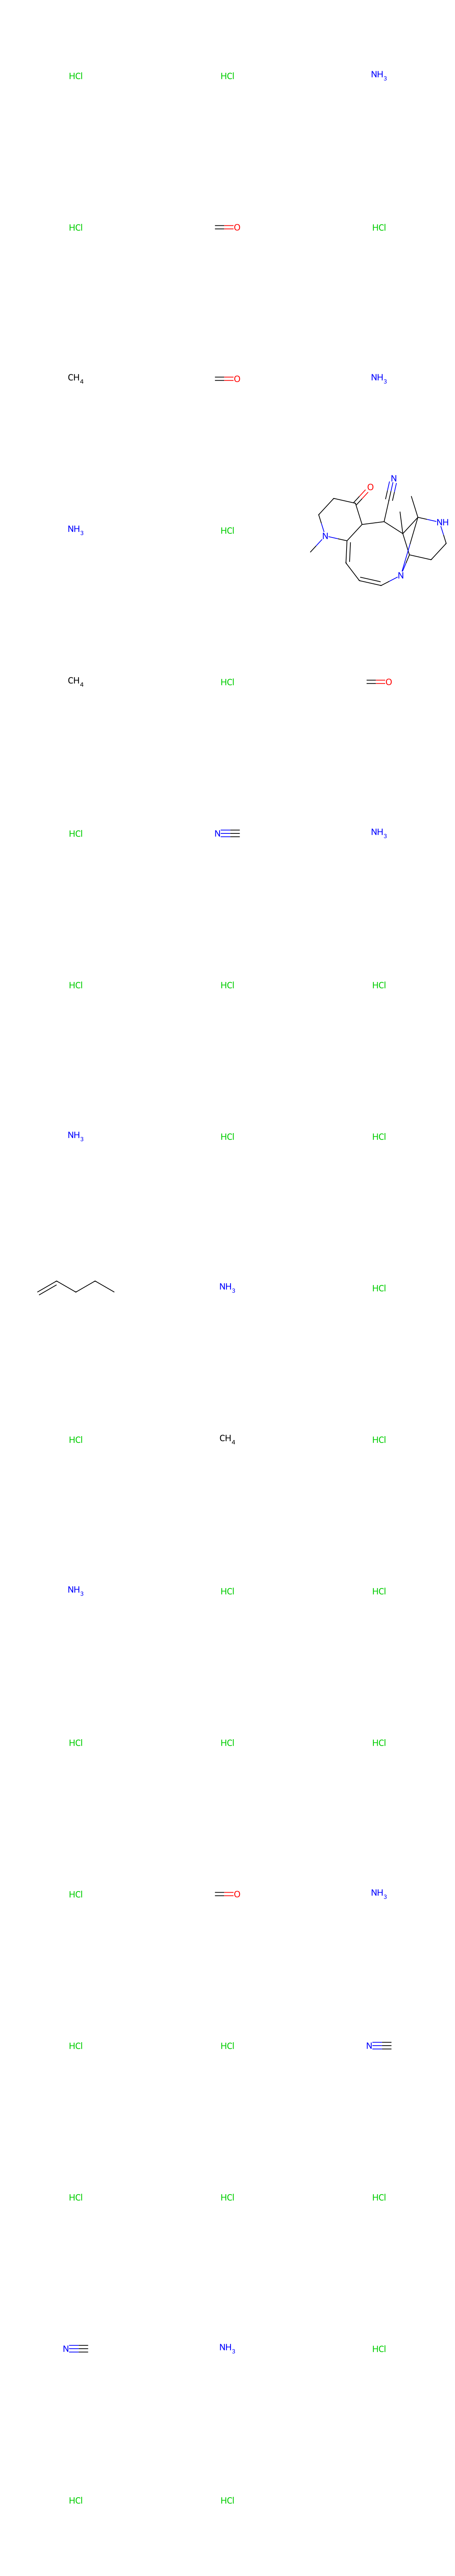

In [ ]:
Draw.MolsToGridImage(t_mols, molsPerRow=3, subImgSize=(400, 400))

In [ ]:
for i in t_smiles:
  print(i)

Cl
Cl
N
Cl
C=O
Cl
C
C=O
N
N
Cl
Cn1CCC(=O)C2C(C#N)C4(C)C3CCNC4(C)N3cccc21
C
Cl
C=O
Cl
C#N
N
Cl
Cl
Cl
N
Cl
Cl
C=CCCC
N
Cl
Cl
C
Cl
N
Cl
Cl
Cl
Cl
Cl
Cl
C=O
N
Cl
Cl
C#N
Cl
Cl
Cl
C#N
N
Cl
Cl
Cl


In [ ]:
Draw.MolsToGridImage([t_mols[1]], molsPerRow=1, subImgSize=(300, 200))